
# **2 Training**

Scientific Computing Infrastructure


## 1. Preparations
### 1.1 Import required packages

In [15]:
import json
import os
import zipfile
import numpy as np
import geopandas as gpd
import sklearn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import importlib

In [16]:
print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

from torch import nn

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


### 1.2 Install segmentation model library

In [17]:
# !pip install segmentation-models-pytorch

In [18]:
import segmentation_models_pytorch as smp

### 1.3 Set device agnostic code

In [19]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU identified")

CUDA available: True
CUDA Version: 12.4
Number of GPUs: 1
GPU Name: Tesla V100-PCIE-32GB


In [20]:
# use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.4 Import data directories and configs-file

In [21]:
import os
print(os.path.abspath("configs"))

/home/sc.uni-leipzig.de/rf37uqip/MoSE/notebooks/configs


In [22]:
# path to repository folder
import sys
sys.path.append(os.path.abspath('/home/sc.uni-leipzig.de/rf37uqip/MoSE/'))

In [23]:
# import configs.py-file
from configs import configs_sc
importlib.reload(configs_sc) # reload changes

<module 'configs.configs_sc' from '/home/sc.uni-leipzig.de/rf37uqip/MoSE/configs/configs_sc.py'>

In [24]:
# input directories: patches and masks
patches_dir = configs_sc.DATA_DIR["patches"]
masks_dir = configs_sc.DATA_DIR["masks"]

# output directories: trained models
saved_model_dir = configs_sc.DATA_DIR["saved_models"]

# additional directories: class (labels and) codes
# labels_dir = configs_sc.DATA_DIR["labels"]
codes_dir = configs_sc.DATA_DIR["codes"]

### 1.5 Import and reload scripts

In [89]:
# import data_utils.py helper-functions script
from scripts import data_utils
importlib.reload(data_utils) # reload changes

# import model_utils.py helper-functions script
from scripts import model_utils
importlib.reload(model_utils) # reload changes

# import train_utils.py helper-functions script
from scripts import train_utils
importlib.reload(train_utils) # reload changes

# import evaluation_utils.py helper-functions script
from scripts import evaluation_utils
importlib.reload(evaluation_utils) # reload changes

# import visualization_utils.py helper function script
from scripts import visualization_utils
importlib.reload(visualization_utils) # reload changes

<module 'scripts.visualization_utils' from '/home/sc.uni-leipzig.de/rf37uqip/MoSE/scripts/visualization_utils.py'>

### 1.6 Check the data

a. Class codes dict

In [26]:
codes_path = os.path.join(codes_dir, "label_codes_ohe.json") # path

# open and load the JSON file
with open(codes_path, "r") as json_file:
    codes = json.load(json_file)

# reversed dictionary
reversed_codes = {v: k for k, v in codes.items()} # v = value, k = key
print(reversed_codes[4])
print(reversed_codes)

gravel bar
{1: 'woody debris', 2: 'rootstock', 3: 'sand/mud bar', 4: 'gravel bar', 0: 'background'}


b. Preprocessed patches

In [27]:
# list of all .npy-files (preprocessed patches)
################################################################################
patches_list = [f for f in os.listdir(patches_dir) if f.endswith('.npy')]
patches_list[0:3], len(patches_list)

(['A01_patch_142.npy', 'A01_patch_0.npy', 'A01_patch_144.npy'], 3836)

Shape of the patches: (3, 512, 512)
Datatype: float64
Type: <class 'numpy.ndarray'>
Mean: 0.17565934532858182
Minimum value: -2.1179039301310043
Maximum value: 2.6225708061002178


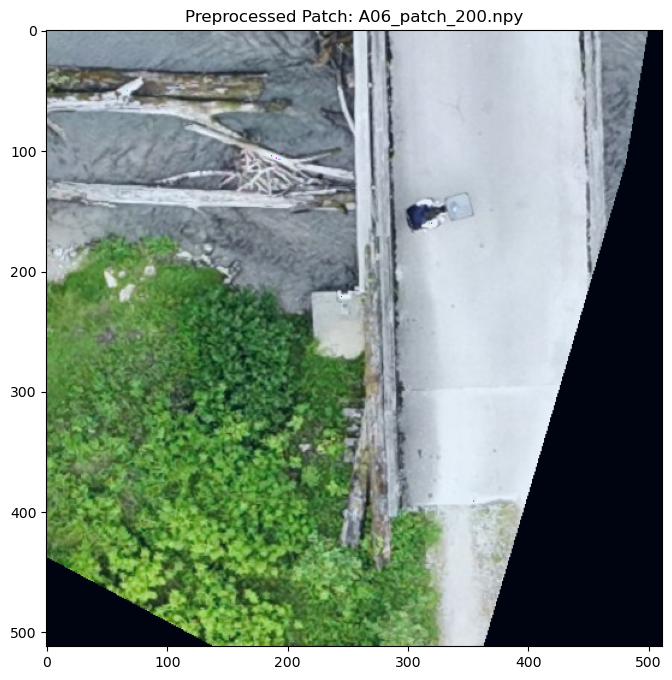

In [28]:
# Test one preprocessed patch
################################################################################

##################### choose single patch by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 200 # -------------------->> ADJUSTABLE
#####################

# load the path to the patch
test_patch_name = f"{SECTION}_patch_{TEST_PATCH_ID}.npy"
test_patch_path = patches_dir + f"/" + test_patch_name

# load npz-file
test_patch = np.load(test_patch_path)

  # Show characteristics of the patch
print("Shape of the patches:", test_patch.shape)
print("Datatype:", test_patch.dtype)
print("Type:", type(test_patch))
print("Mean:", np.mean(test_patch))
print("Minimum value:", np.min(test_patch))
print("Maximum value:", np.max(test_patch))

# import the norm_plot_patch function for normalization and plotting of the test patch
visualization_utils.norm_plot_patch(test_patch, test_patch_name)

3. Masks

In [29]:
# list of all masks
################################################################################

masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # list of all masks
print(masks_list[0:3])
len(masks_list)

['A01_patch_180_mask.npy', 'A01_patch_0_mask.npy', 'A01_patch_138_mask.npy']


3836

In [30]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 200 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen mask
test_mask_name = f"{SECTION}_patch_{TEST_MASK_ID}_mask.npy"
test_mask_path = masks_dir + f"/" + test_mask_name

# Load mask
test_mask = np.load(test_mask_path)

# Show properties of the mask
print("Shape of the mask:", test_mask.shape)
print("Datatype:", test_mask.dtype)
print("Type:", type(test_mask))
print("Minimum value:", np.min(test_mask))
print("Maximum value:", np.max(test_mask))
print("Unique values:", np.unique(test_mask), "\n") # binary mask



Shape of the mask: (5, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 1
Unique values: [0 1] 



Plot the mask

A06_patch_200_mask.npy


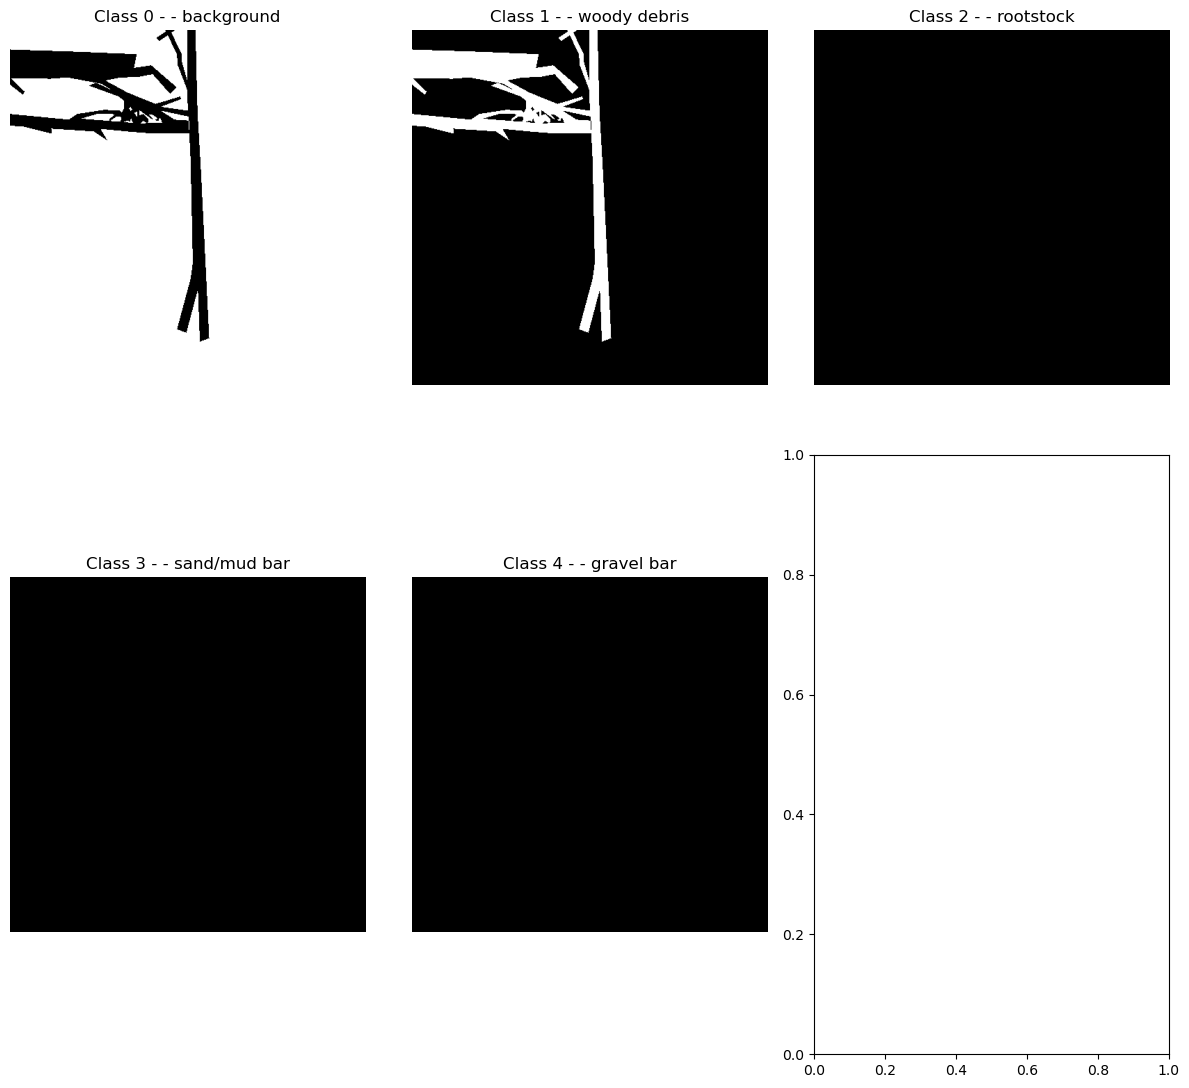

In [31]:
# ONE-HOT-ENCODED
print(test_mask_name)
fig, axes = plt.subplots(2, 3, figsize=(12, 12))  # 2x3 grid (for 5 classes)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask.shape[0]):  # iterate through the classes
  axes[i].imshow(test_mask[i], cmap="gray")
  axes[i].set_title(f"Class {i} - - {reversed_codes[i]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

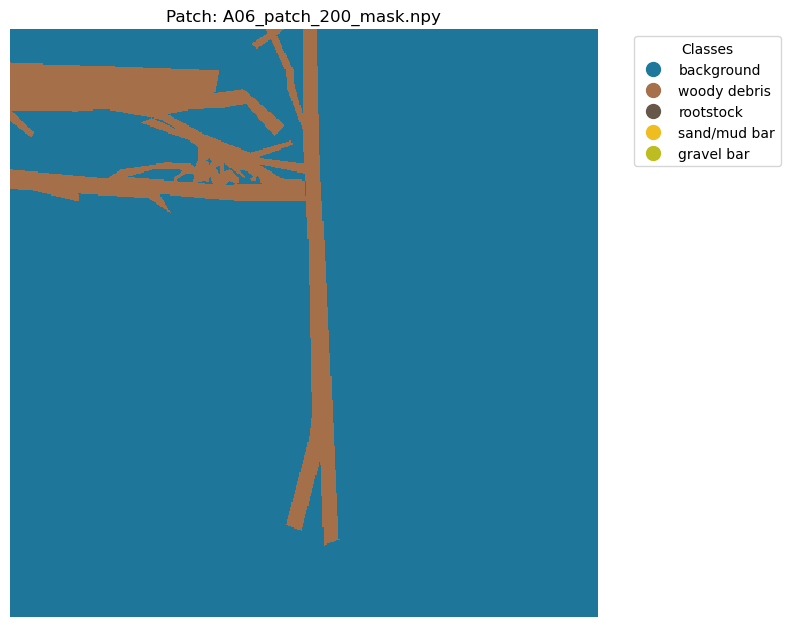

In [32]:
# alternative way of plotting the masks - not in one-hot-encoded, but in class-index-format
# CLASS-INDEX-FORMAT

# convert into class-index format
test_mask_idxformat = np.argmax(test_mask, axis=0)

visualization_utils.plot_mask_idxformat(test_mask_idxformat, test_mask_name, reversed_codes, configs_sc.HYPERPARAMETERS["custom_colors"])

## 2. Splitting data into train and test datasets

In [33]:
# extract section and patch_id from masks and patches (utils function)
print(data_utils.extract_section_and_id(masks_list[2]))
print(data_utils.extract_section_and_id(patches_list[175]))

('A01', '138')
('A01', '255')


In [34]:
# group patches by section
################################################################################

section_patches = {} # empty dictionary
for patch in patches_list: # iterate over all preprocessed patches
    section, patch_id = data_utils.extract_section_and_id(patch) # extract section and id
    section_patches.setdefault(section, []).append((patch)) # creates keys of sections with their patches inside

print(section_patches.keys())
# print(section_patches)

dict_keys(['A01', 'A02', 'A04', 'A06', 'A03', 'A05', 'A07', 'A08'])


In [35]:
# Separate patches in Training and Validation/Test datasets by sections
################################################################################

# empty lists for patches
train_data = []
test_data = []

for section, files in section_patches.items(): # iterates through the dictionary of sections
    if section in configs_sc.HYPERPARAMETERS["train_sections"]: # if the section is a training section
        train_data.extend(files) # if yes, the patches are added to the training data
    elif section in configs_sc.HYPERPARAMETERS["test_sections"]:
        test_data.extend(files)

print(f"Training Patches: {len(train_data)}")
print(f"Test Patches: {len(test_data)}")
print(f"Testdata-Ratio: {100*(len(test_data)/len(train_data))}")
print(f"Traindata-Ratio: {100 - 100*(len(test_data)/len(train_data))}")

Training Patches: 3077
Test Patches: 759
Testdata-Ratio: 24.666883327916803
Traindata-Ratio: 75.3331166720832


In [36]:
# Show random patch name in training data
print(train_data[8])

# test if this random patch has a corresponding mask
data_utils.has_mask(train_data[8], masks_dir)

A01_patch_146.npy


True

In [37]:
# Separate training and test patches 
################################################################################

train_data = [f for f in train_data if data_utils.has_mask(f, masks_dir)]
test_data = [f for f in test_data if data_utils.has_mask(f, masks_dir)]

print(f"Training data- Number of patches: {len(train_data)}")
print(f"Test data - Number of patches: {len(test_data)}")

Training data- Number of patches: 3077
Test data - Number of patches: 759


## 3. Data augmentation, Dataset and DataLoader

### 3.1 Data augmentation

In [38]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define training transformations with augmentation using Albumentations
train_transforms = A.Compose([
    
    # horizontal flip with a probability of 0.5
    A.HorizontalFlip(p=0.5),
    # vertical flip 
    A.VerticalFlip(p=0.5), 
    # randomly rotate the image by 90 degrees 
    A.RandomRotate90(p=0.5), 
    # random adjustments to brightness, contrast, saturation, and hue
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5), 
    # affine transformation:
    A.Affine(rotate=(-90, 90), translate_percent=(-0.1, 0.1), scale=(0.9, 1.1), p=0.5),
    # - rotate: randomly rotate within the range (-90, 90) degrees
    # - translate_percent: randomly translate by up to ±10% of image dimensions
    # - scale: randomly scale the image between 0.9 and 1.1 times its original size
    # normalize the image using ImageNet statistics
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    # covert to Tensors
    ToTensorV2() 
], additional_targets={'mask': 'mask'}) # ensures the same transformation is applied to the mask


# Define test transformations without augmentation (only normalization and conversion to tensor)
test_transforms = A.Compose([
    # normalize the image using ImageNet statistics
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    # covert to Tensors
    ToTensorV2() 
], additional_targets={'mask': 'mask'}) # ensures the same transformation is applied to the mask

### 3.2 Dataset

In [ ]:
# # with Data augmentation
# ################################
# # Apply Datasets and check properties
# ################################################################################

# # Train dataset
# train_dataset = data_utils.PatchDatasetCplx(train_data, patches_dir, masks_dir, transform = train_transforms)

# # check properties of the train dataset:
# print("Train dataset:\n")
# print("Type of dataset:", type(train_dataset))
# print("Number of patches:", len(train_dataset))
# print("Random patch:", train_dataset[0][0])
# print("Patch shape:", train_dataset[0][1].shape)
# print("Mask shape:", train_dataset[0][2].shape, "\n")

# # Test datasets
# test_dataset = data_utils.PatchDatasetCplx(test_data, patches_dir, masks_dir, transform = test_transforms) 

# # check properties of the test dataset:
# print("Test dataset:\n")
# print("Type of dataset:", type(test_dataset))
# print("Number of patches:", len(test_dataset))
# print("Random patch:", test_dataset[0][0])
# print("Patch shape:", test_dataset[0][1].shape)
# print("Mask shape:", test_dataset[0][2].shape, "\n")

Train dataset:

Type of dataset: <class 'scripts.data_utils.PatchDatasetCplx'>
Number of patches: 3077
Random patch: A01_patch_142.npy
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512]) 

Test dataset:

Type of dataset: <class 'scripts.data_utils.PatchDatasetCplx'>
Number of patches: 759
Random patch: A04_patch_30.npy
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512]) 



In [ ]:
# without Data augmentation
###############################
# Apply Datasets and check properties
################################################################################

# Train dataset
train_dataset = data_utils.PatchDatasetSimple(train_data, patches_dir, masks_dir)

# check properties of the train dataset:
print("Train dataset:\n")
print("Type of dataset:", type(train_dataset))
print("Number of patches:", len(train_dataset))
print("Random patch:", train_dataset[0][0])
print("Patch shape:", train_dataset[0][1].shape)
print("Mask shape:", train_dataset[0][2].shape, "\n")

# Simple Test dataset
test_dataset = data_utils.PatchDatasetSimple(test_data, patches_dir, masks_dir) 

# check properties of the test dataset:
print("Simple Test dataset:\n")
print("Type of dataset:", type(test_dataset))
print("Number of patches:", len(test_dataset))
print("Random patch:", test_dataset[0][0])
print("Patch shape:", test_dataset[0][1].shape)
print("Mask shape:", test_dataset[0][2].shape, "\n")

Simple Test dataset:

Type of dataset: <class 'scripts.data_utils.PatchDatasetCplx'>
Number of patches: 759
Random patch: A04_patch_30.npy
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512]) 



### 3.3 DataLoader

Right now the data is in the form of Pytorch Datasets (see above). The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or simply `DataLoader`.

The `DataLoader`
- helps load data into the model.
- for training and for inference.
- **turns a large `Dataset` into a Python iterable** of smaller chunks. These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = configs_sc.HYPERPARAMETERS["batch_size"]

# Train DataLoader
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print("Dataloader:", train_loader)

# Test DataLoader
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Check dataloader
print(f"Training Batches: {len(train_loader)}", f"= up to {len(train_loader)*BATCH_SIZE} patches")
print(f"Test Batches: {len(test_loader)}", f"= up to {len(test_loader)*BATCH_SIZE} patches")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x14aa4a70a9f0>
Training Batches: 385 = up to 3080 patches
Test Batches: 95 = up to 760 patches


### 3.4 Data exploration and class weights

In [42]:
# # Explore one batch of data in train_loader
# for batch_idx, (names, images, masks) in enumerate(train_loader):
#     print(f"Batch {batch_idx + 1}:", "\n------------\n------------")
#     print(f"Names - first patch name of the batch: {names[0]}", "\n------------")
#     print(f"Image type: {type(images)}")
#     print(f"Images shape: {images.shape}")  # Should be [batch_size, channels, height, width]
#     print(f"Image excerpt of the first patch: {images[0,:,:4,:4]}")
#     print(f"Images dtype: {images.dtype}", "\n------------")
#     print(f"Masks shape: {masks.shape}")    # Should be [batch_size, channels, height, width]
#     print(f"Mask excerpt of the mask of the fourth patch: {masks[0,:,:2,:2]}")
#     print(f"Masks dtype: {masks.dtype}")
#     break # break after first batch (batch 1)

In [ ]:
# TRAIN LOADER
# Show pixel distribution per class in train_loader
pixel_distribution_train = data_utils.pixel_distribution_dataloader(
    data_loader=train_loader,
    num_classes= configs_sc.HYPERPARAMETERS["num_classes"],
    device=device
)

# Visualize results
plt.bar(pixel_distribution_train.keys(), pixel_distribution_train.values())
plt.xlabel("Class")
plt.ylabel("Percentage of Pixels (%)")
plt.title("Pixel Distribution Across Classes (Train Dataset)")
plt.xticks()
plt.show()

In [44]:
# # TEST LOADER
# # Show pixel distribution per class in test_loader
# pixel_distribution_test = data_utils.pixel_distribution_dataloader(
#     data_loader=test_loader,
#     num_classes= configs_sc.HYPERPARAMETERS["num_classes"],
#     device=device
# )

# # Visualize results
# plt.bar(pixel_distribution_test.keys(), pixel_distribution_test.values())
# plt.xlabel("Class")
# plt.ylabel("Percentage of Pixels (%)")
# plt.title("Pixel Distribution Across Classes (Test Dataset)")
# plt.xticks()
# plt.show()

In [ ]:
pixel_dist_train = torch.tensor(list(pixel_distribution_train.values()), dtype=torch.float32, device=device)
# pixel_dist_train = torch.tensor([98.5564,  1.4437], dtype=torch.float32, device=device)
print("Pixel distribution in train dataset:", pixel_dist_train)

Pixel distribution in train dataset: tensor([98.5564,  1.4437], device='cuda:0')


In [46]:
# calculate the (inverse proportional) weights to outweigh the class imbalances
class_weights = 1/ (pixel_dist_train/100)
print("Class weights:", class_weights)

normalized_weights = class_weights / class_weights.sum()
print("Normalized weights:", normalized_weights)

Class weights: tensor([ 1.0146, 69.2665], device='cuda:0')
Normalized weights: tensor([0.0144, 0.9856], device='cuda:0')


To take into account the class imbalances in this dataset, we adjust the weight parameters in the CrossEntropyLoss function accordingly. Based on the pixel distribution, the weights can be set as follows:

| Class | Average pixel distribution (%) | Normalized Weight |
| ----- | ----- | ----- |
| 0 | 98.5564 | 0.0144 |
| 1 | 1.4437   | 0.9856 |


(
| 2 | 0.1185 | 0.5546 |
| 3 | 0.2076 | 0.3164 |
| 4 | 0.7930 | 0.0829 |
)

## 4. Segmentation model

U-Net is a fully convolution neural network for image semantic segmentation. Consist of encoder and decoder parts connected with skip connections. Encoder extract features of different spatial resolution (skip connections) which are used by decoder to define accurate segmentation mask. 

URL: https://smp.readthedocs.io/en/latest/models.html#unet

In [47]:
################################################################################
# model_0 = smp.Unet(   # -------------------->> ADJUSTABLE
#     encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (3 for RGB)
#     classes=configs_sc.HYPERPARAMETERS["num_classes"],       # model output channels (number of classes)
# )
################################################################################

In [48]:
model = model_utils.model_0.to(device)

In [49]:
# show model costruction
# model.to(device)

In [50]:
# show (hidden) layers of the model
# model.state_dict().keys()

In [51]:
next(model.parameters()).device

device(type='cuda', index=0)

### 4.1 Setup loss, optimizer and evaluation metrics

Setup loss function and optimizer

In [52]:
# Setup loss function
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss(weight = normalized_weights).to(device)

In [53]:
# Setup optimizer
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(model.parameters(), configs_sc.HYPERPARAMETERS["learning_rate"], betas=(0.9, 0.999))

# AdamW = Adam with weight decay
from torch.optim import AdamW

optimizer = AdamW(
    model.parameters(),
    lr=configs_sc.HYPERPARAMETERS["learning_rate"],  # learning rate
    weight_decay=1e-4  # regularisation
)

Evaluation metrics

In [54]:
accuracy_fn = evaluation_utils.oa_accuracy_fn

### 4.2 Training and test loop

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss per batch.
3. Loop through testing batches, perform testing steps, calculate the test loss per batch.

Learning rate: 1e-06
Number of epochs: 50


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss of [Batch 0/385]: 0.8603
Train Loss of [Batch 100/385]: 0.8872
Train Loss of [Batch 200/385]: 0.8340
Train Loss of [Batch 300/385]: 0.7708

Train loss: 0.86137 | Train accuracy: 72.37%
Train Class-wise Loss: tensor([0.9541, 0.7396], device='cuda:0')

Test loss: 0.81810 | Test accuracy: 71.39%
Test Class-wise Loss: tensor([1.0616, 0.5457], device='cuda:0')



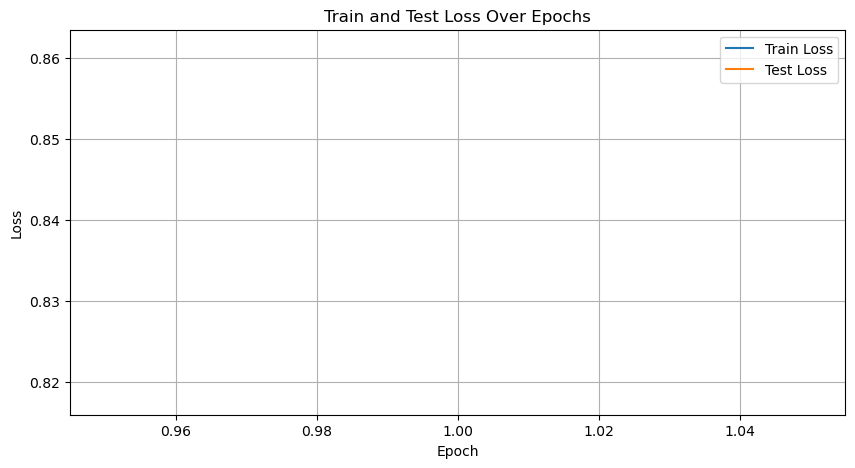

Epoch: 1
---------
Train Loss of [Batch 0/385]: 0.6745
Train Loss of [Batch 100/385]: 0.7921
Train Loss of [Batch 200/385]: 0.7651
Train Loss of [Batch 300/385]: 0.8568

Train loss: 0.75715 | Train accuracy: 74.46%
Train Class-wise Loss: tensor([0.9097, 0.5593], device='cuda:0')

Test loss: 0.70975 | Test accuracy: 71.84%
Test Class-wise Loss: tensor([1.0656, 0.3949], device='cuda:0')



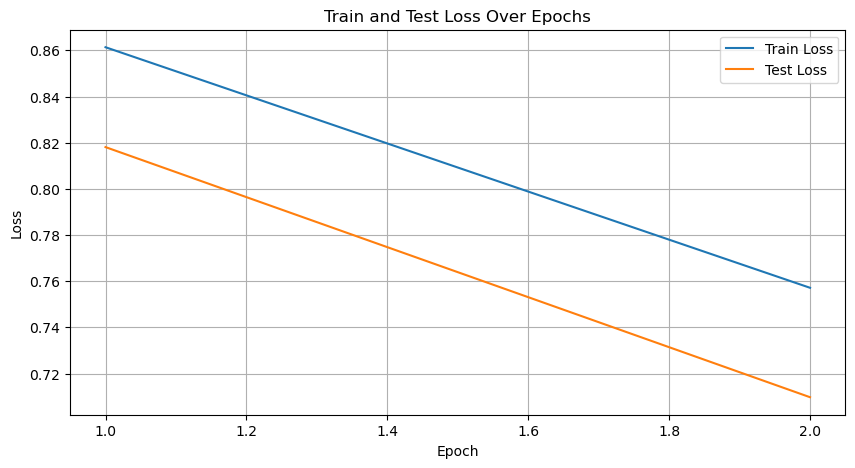

Epoch: 2
---------
Train Loss of [Batch 0/385]: 0.6385
Train Loss of [Batch 100/385]: 0.7074
Train Loss of [Batch 200/385]: 0.5963
Train Loss of [Batch 300/385]: 0.7782

Train loss: 0.69277 | Train accuracy: 76.31%
Train Class-wise Loss: tensor([0.8695, 0.4672], device='cuda:0')

Test loss: 0.64925 | Test accuracy: 73.35%
Test Class-wise Loss: tensor([1.1026, 0.3053], device='cuda:0')



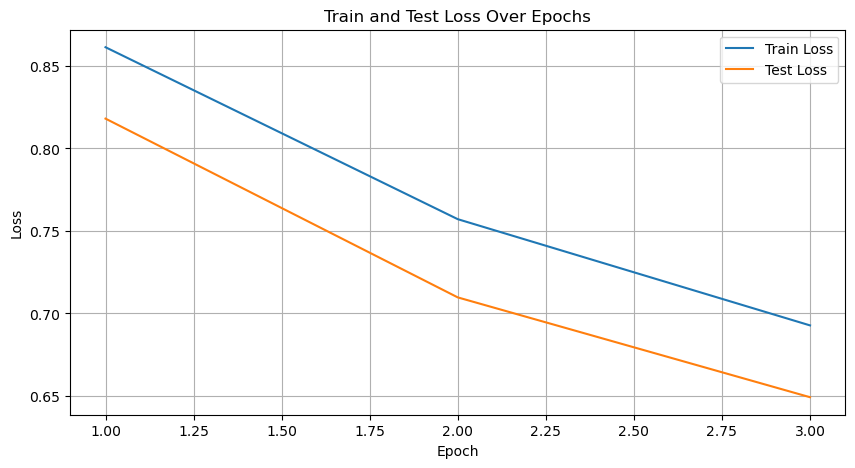

Epoch: 3
---------
Train Loss of [Batch 0/385]: 0.5836
Train Loss of [Batch 100/385]: 0.7208
Train Loss of [Batch 200/385]: 0.6531
Train Loss of [Batch 300/385]: 0.5951

Train loss: 0.65401 | Train accuracy: 78.37%
Train Class-wise Loss: tensor([0.8293, 0.4290], device='cuda:0')

Test loss: 0.60232 | Test accuracy: 75.04%
Test Class-wise Loss: tensor([1.0479, 0.2822], device='cuda:0')



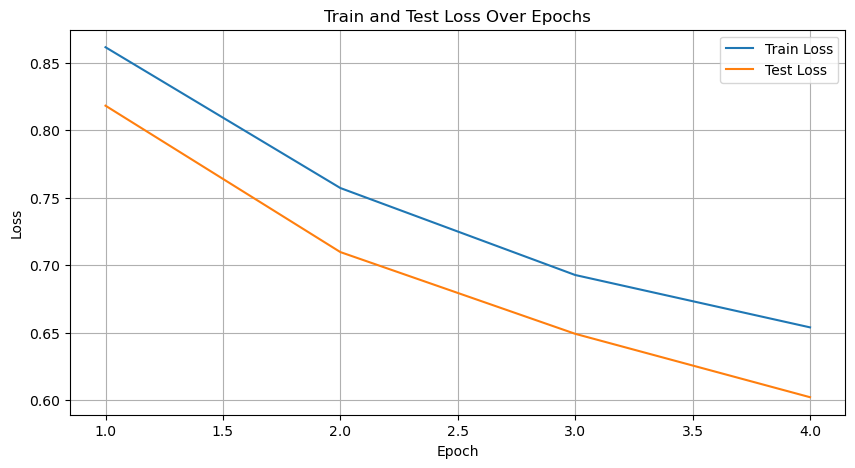

Epoch: 4
---------
Train Loss of [Batch 0/385]: 0.6717
Train Loss of [Batch 100/385]: 0.7345
Train Loss of [Batch 200/385]: 0.6214
Train Loss of [Batch 300/385]: 0.5977

Train loss: 0.61257 | Train accuracy: 80.61%
Train Class-wise Loss: tensor([0.7873, 0.3798], device='cuda:0')

Test loss: 0.55089 | Test accuracy: 78.18%
Test Class-wise Loss: tensor([0.9363, 0.2854], device='cuda:0')



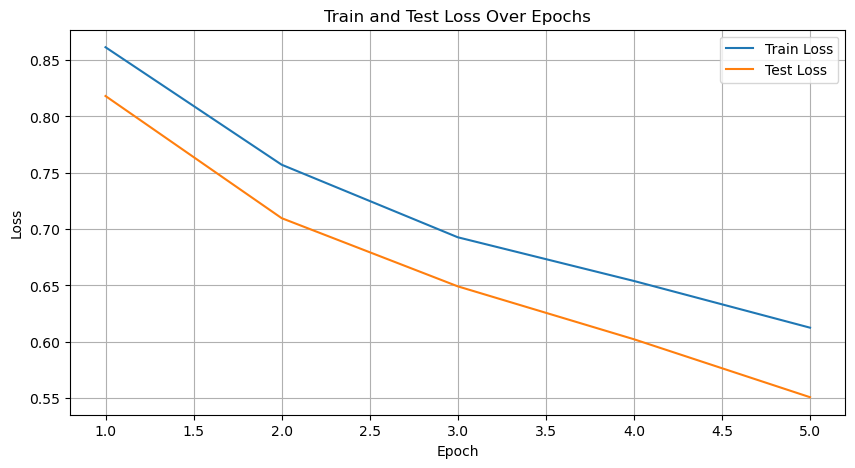

Epoch: 5
---------
Train Loss of [Batch 0/385]: 0.5424
Train Loss of [Batch 100/385]: 0.4893
Train Loss of [Batch 200/385]: 0.4299
Train Loss of [Batch 300/385]: 0.6639

Train loss: 0.58760 | Train accuracy: 82.31%
Train Class-wise Loss: tensor([0.7524, 0.3774], device='cuda:0')

Test loss: 0.52006 | Test accuracy: 79.42%
Test Class-wise Loss: tensor([0.9073, 0.2653], device='cuda:0')



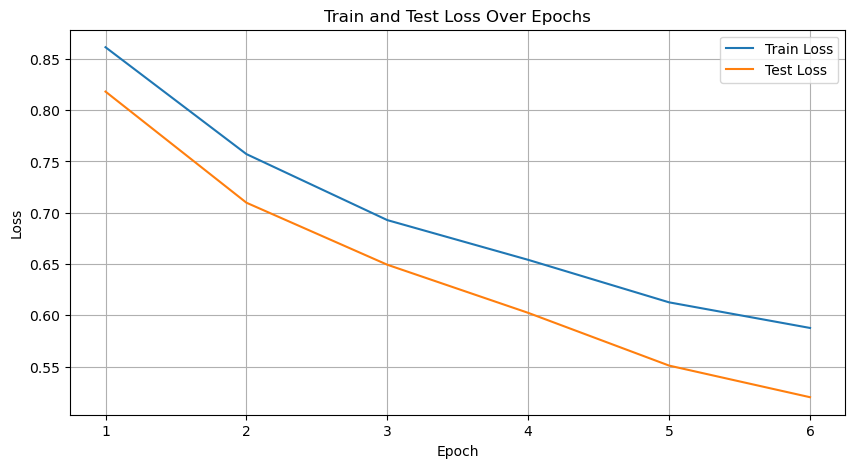

Epoch: 6
---------
Train Loss of [Batch 0/385]: 0.7017
Train Loss of [Batch 100/385]: 0.5372
Train Loss of [Batch 200/385]: 0.5223
Train Loss of [Batch 300/385]: 0.4850

Train loss: 0.56380 | Train accuracy: 84.04%
Train Class-wise Loss: tensor([0.7164, 0.3669], device='cuda:0')

Test loss: 0.48481 | Test accuracy: 82.10%
Test Class-wise Loss: tensor([0.8031, 0.2814], device='cuda:0')



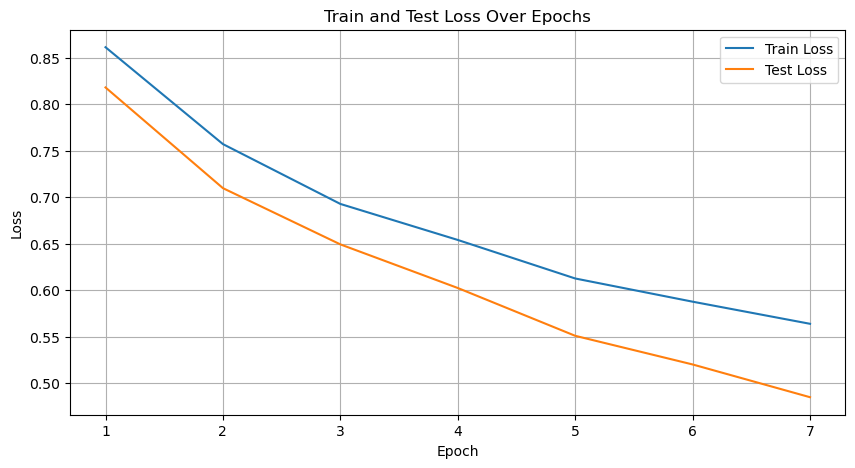

Epoch: 7
---------
Train Loss of [Batch 0/385]: 0.5482
Train Loss of [Batch 100/385]: 0.5095
Train Loss of [Batch 200/385]: 0.6158
Train Loss of [Batch 300/385]: 0.5916

Train loss: 0.54081 | Train accuracy: 85.61%
Train Class-wise Loss: tensor([0.6818, 0.3617], device='cuda:0')

Test loss: 0.46665 | Test accuracy: 82.48%
Test Class-wise Loss: tensor([0.7866, 0.2690], device='cuda:0')



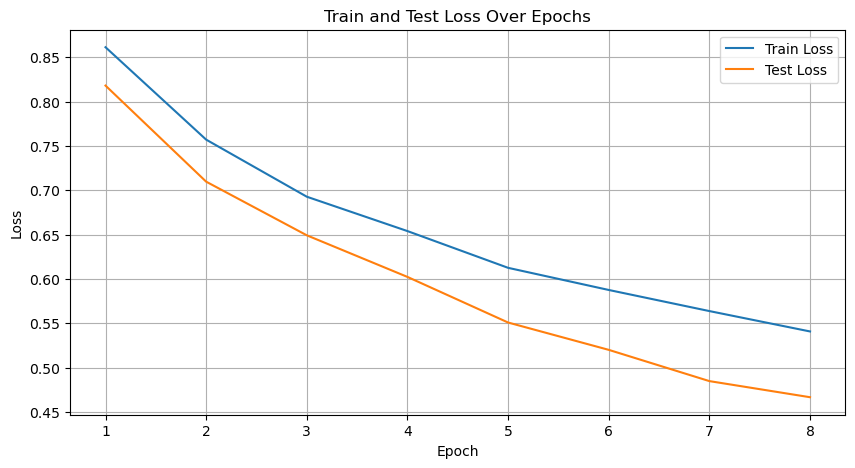

Epoch: 8
---------
Train Loss of [Batch 0/385]: 0.5841
Train Loss of [Batch 100/385]: 0.4867
Train Loss of [Batch 200/385]: 0.6256
Train Loss of [Batch 300/385]: 0.3886

Train loss: 0.52530 | Train accuracy: 86.77%
Train Class-wise Loss: tensor([0.6493, 0.3717], device='cuda:0')

Test loss: 0.44974 | Test accuracy: 82.93%
Test Class-wise Loss: tensor([0.7944, 0.2397], device='cuda:0')



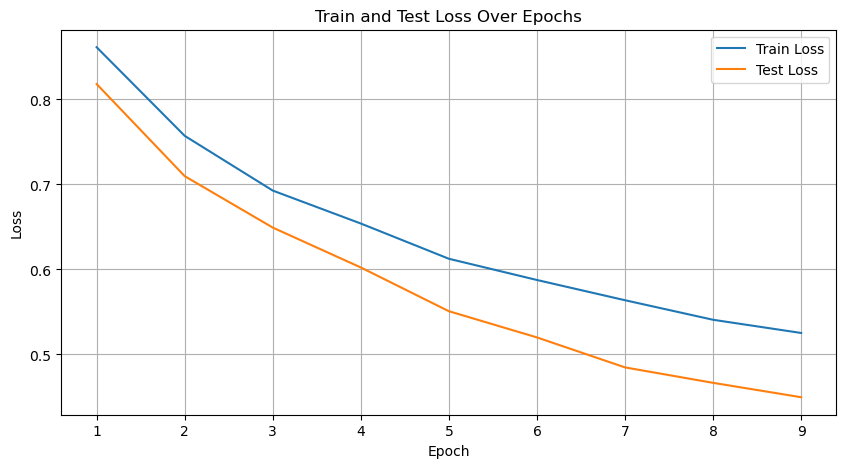

Epoch: 9
---------
Train Loss of [Batch 0/385]: 0.4794
Train Loss of [Batch 100/385]: 0.4756
Train Loss of [Batch 200/385]: 0.4970
Train Loss of [Batch 300/385]: 0.5932

Train loss: 0.50288 | Train accuracy: 87.85%
Train Class-wise Loss: tensor([0.6197, 0.3551], device='cuda:0')

Test loss: 0.43669 | Test accuracy: 82.58%
Test Class-wise Loss: tensor([0.7945, 0.2208], device='cuda:0')



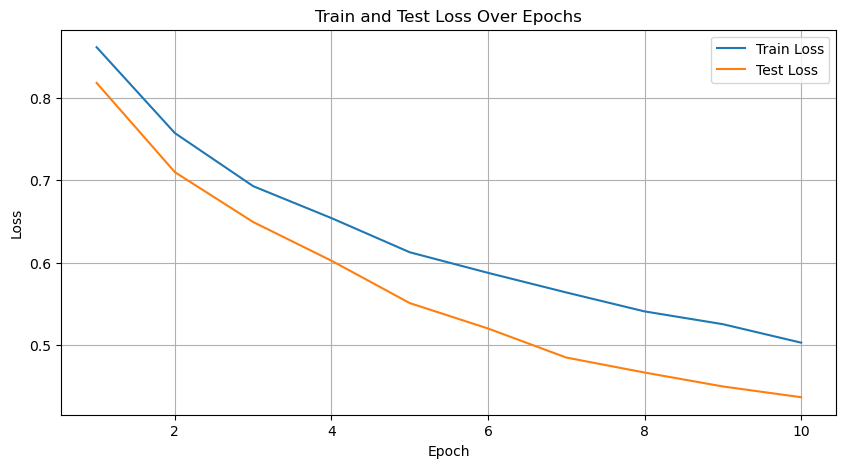

Epoch: 10
---------
Train Loss of [Batch 0/385]: 0.5312
Train Loss of [Batch 100/385]: 0.5284
Train Loss of [Batch 200/385]: 0.5936
Train Loss of [Batch 300/385]: 0.5032

Train loss: 0.48392 | Train accuracy: 88.54%
Train Class-wise Loss: tensor([0.5948, 0.3493], device='cuda:0')

Test loss: 0.41911 | Test accuracy: 82.93%
Test Class-wise Loss: tensor([0.7551, 0.2249], device='cuda:0')



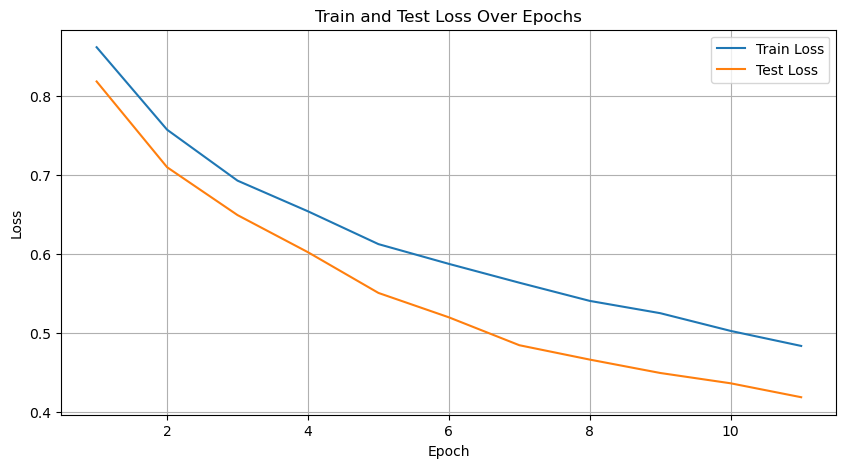

Epoch: 11
---------
Train Loss of [Batch 0/385]: 0.4115
Train Loss of [Batch 100/385]: 0.3943
Train Loss of [Batch 200/385]: 0.4826
Train Loss of [Batch 300/385]: 0.4455

Train loss: 0.47090 | Train accuracy: 88.87%
Train Class-wise Loss: tensor([0.5720, 0.3449], device='cuda:0')

Test loss: 0.39368 | Test accuracy: 85.48%
Test Class-wise Loss: tensor([0.6509, 0.2661], device='cuda:0')



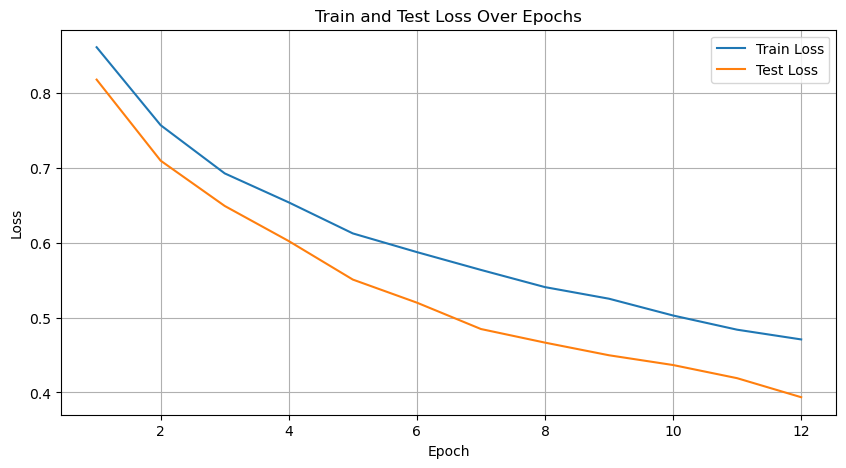

Epoch: 12
---------
Train Loss of [Batch 0/385]: 0.3903
Train Loss of [Batch 100/385]: 0.4291
Train Loss of [Batch 200/385]: 0.6182
Train Loss of [Batch 300/385]: 0.3720

Train loss: 0.45785 | Train accuracy: 89.06%
Train Class-wise Loss: tensor([0.5530, 0.3365], device='cuda:0')

Test loss: 0.39852 | Test accuracy: 82.84%
Test Class-wise Loss: tensor([0.7310, 0.2088], device='cuda:0')



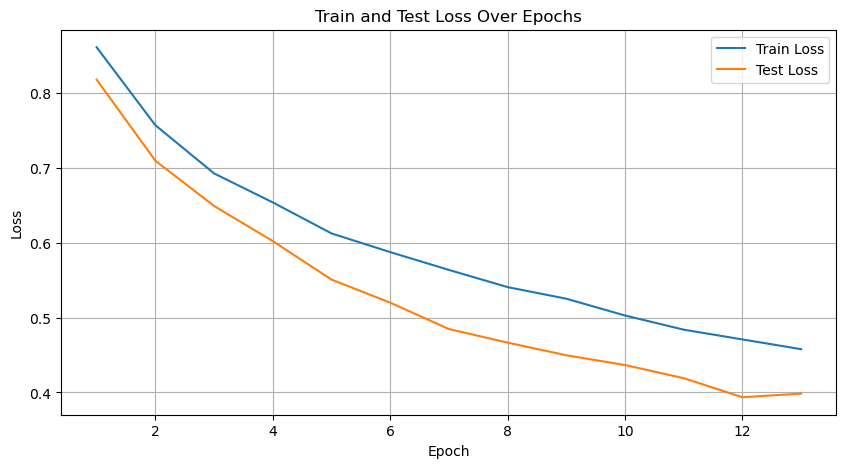

Epoch: 13
---------
Train Loss of [Batch 0/385]: 0.4057
Train Loss of [Batch 100/385]: 0.5125
Train Loss of [Batch 200/385]: 0.4589
Train Loss of [Batch 300/385]: 0.3384

Train loss: 0.44425 | Train accuracy: 89.58%
Train Class-wise Loss: tensor([0.5303, 0.3409], device='cuda:0')

Test loss: 0.37405 | Test accuracy: 84.89%
Test Class-wise Loss: tensor([0.6298, 0.2478], device='cuda:0')



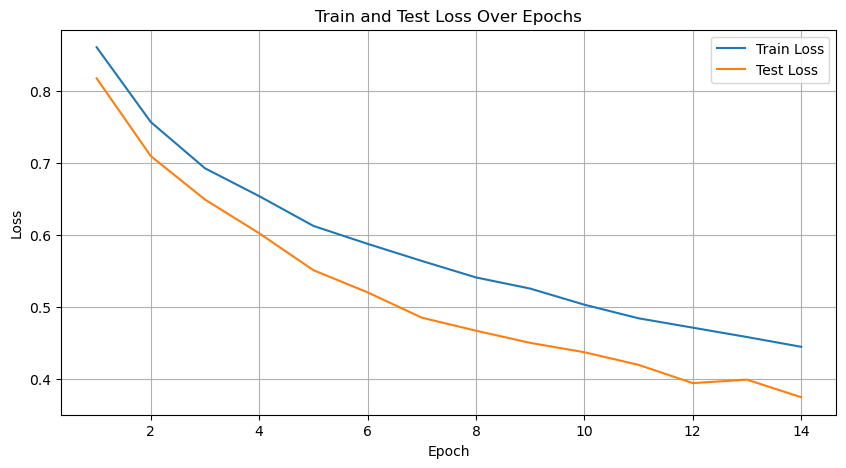

Epoch: 14
---------
Train Loss of [Batch 0/385]: 0.4693
Train Loss of [Batch 100/385]: 0.5454
Train Loss of [Batch 200/385]: 0.4267
Train Loss of [Batch 300/385]: 0.3899

Train loss: 0.43842 | Train accuracy: 89.59%
Train Class-wise Loss: tensor([0.5142, 0.3409], device='cuda:0')

Test loss: 0.36264 | Test accuracy: 85.92%
Test Class-wise Loss: tensor([0.5889, 0.2616], device='cuda:0')



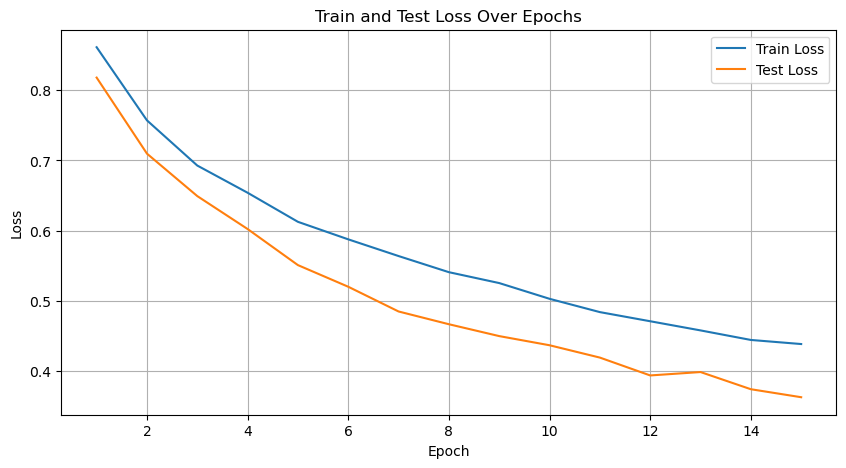

Epoch: 15
---------
Train Loss of [Batch 0/385]: 0.4402
Train Loss of [Batch 100/385]: 0.6307
Train Loss of [Batch 200/385]: 0.4667
Train Loss of [Batch 300/385]: 0.5549

Train loss: 0.42443 | Train accuracy: 89.75%
Train Class-wise Loss: tensor([0.4988, 0.3327], device='cuda:0')

Test loss: 0.36067 | Test accuracy: 83.98%
Test Class-wise Loss: tensor([0.6316, 0.2283], device='cuda:0')



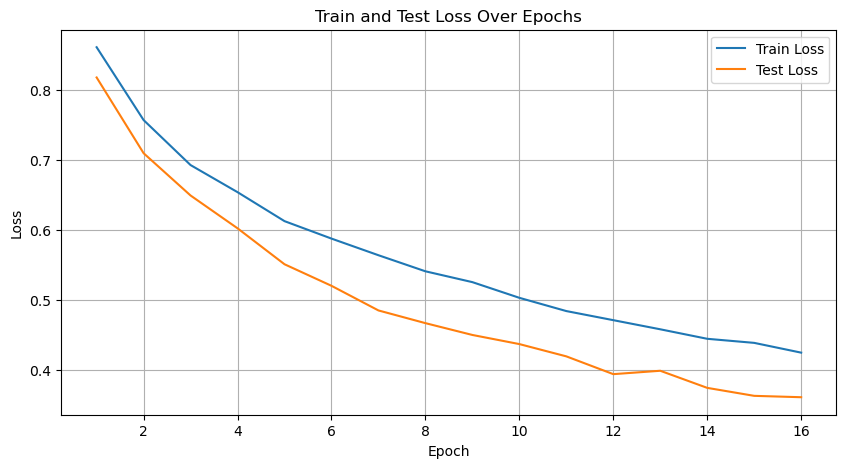

Epoch: 16
---------
Train Loss of [Batch 0/385]: 0.5804
Train Loss of [Batch 100/385]: 0.4180
Train Loss of [Batch 200/385]: 0.5011
Train Loss of [Batch 300/385]: 0.3098

Train loss: 0.41427 | Train accuracy: 89.80%
Train Class-wise Loss: tensor([0.4850, 0.3270], device='cuda:0')

Test loss: 0.34871 | Test accuracy: 84.79%
Test Class-wise Loss: tensor([0.6075, 0.2264], device='cuda:0')



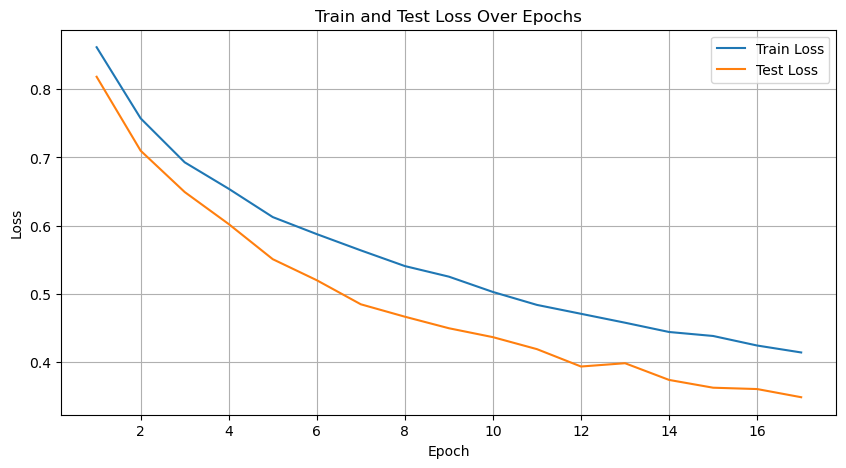

Epoch: 17
---------
Train Loss of [Batch 0/385]: 0.3896
Train Loss of [Batch 100/385]: 0.3833
Train Loss of [Batch 200/385]: 0.3911
Train Loss of [Batch 300/385]: 0.4328

Train loss: 0.40581 | Train accuracy: 89.90%
Train Class-wise Loss: tensor([0.4716, 0.3214], device='cuda:0')

Test loss: 0.35136 | Test accuracy: 83.44%
Test Class-wise Loss: tensor([0.6292, 0.2193], device='cuda:0')



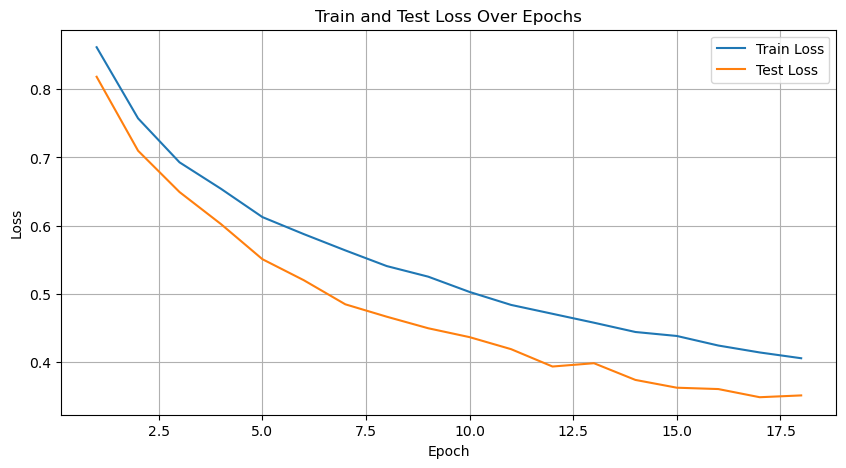

Epoch: 18
---------
Train Loss of [Batch 0/385]: 0.3427
Train Loss of [Batch 100/385]: 0.3606
Train Loss of [Batch 200/385]: 0.2941
Train Loss of [Batch 300/385]: 0.3144

Train loss: 0.40432 | Train accuracy: 90.11%
Train Class-wise Loss: tensor([0.4564, 0.3459], device='cuda:0')

Test loss: 0.33829 | Test accuracy: 84.87%
Test Class-wise Loss: tensor([0.5662, 0.2413], device='cuda:0')



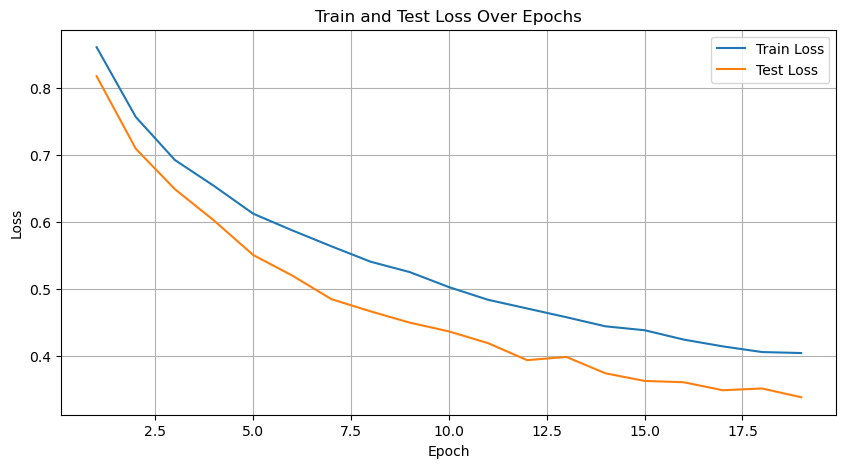

Epoch: 19
---------
Train Loss of [Batch 0/385]: 0.5125
Train Loss of [Batch 100/385]: 0.3172
Train Loss of [Batch 200/385]: 0.4967
Train Loss of [Batch 300/385]: 0.4168

Train loss: 0.39819 | Train accuracy: 89.95%
Train Class-wise Loss: tensor([0.4468, 0.3435], device='cuda:0')

Test loss: 0.33032 | Test accuracy: 85.93%
Test Class-wise Loss: tensor([0.5209, 0.2701], device='cuda:0')



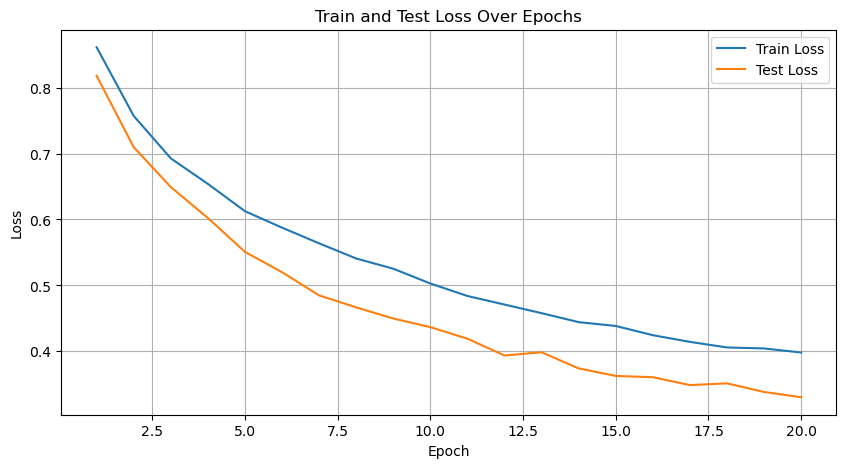

Epoch: 20
---------
Train Loss of [Batch 0/385]: 0.3512
Train Loss of [Batch 100/385]: 0.3137
Train Loss of [Batch 200/385]: 0.3816
Train Loss of [Batch 300/385]: 0.4587

Train loss: 0.38551 | Train accuracy: 90.01%
Train Class-wise Loss: tensor([0.4366, 0.3240], device='cuda:0')

Test loss: 0.33815 | Test accuracy: 82.63%
Test Class-wise Loss: tensor([0.6197, 0.2021], device='cuda:0')



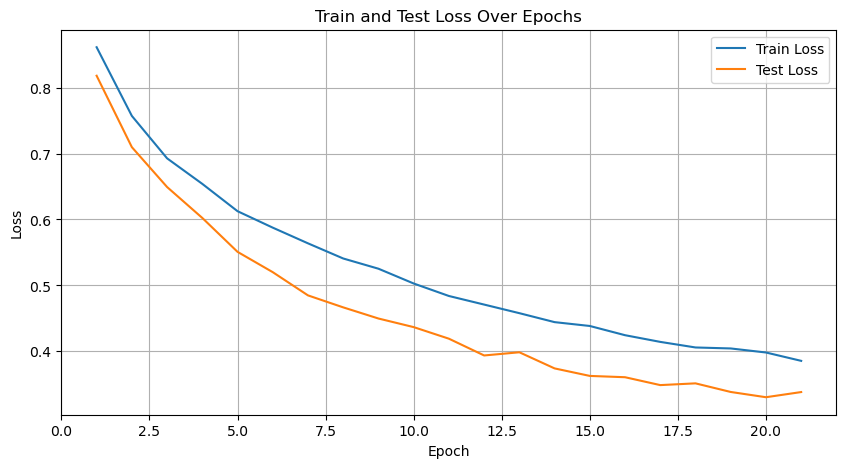

Epoch: 21
---------
Train Loss of [Batch 0/385]: 0.4114
Train Loss of [Batch 100/385]: 0.3203
Train Loss of [Batch 200/385]: 0.3815
Train Loss of [Batch 300/385]: 0.3817

Train loss: 0.38778 | Train accuracy: 90.00%
Train Class-wise Loss: tensor([0.4273, 0.3423], device='cuda:0')

Test loss: 0.32040 | Test accuracy: 84.73%
Test Class-wise Loss: tensor([0.5351, 0.2408], device='cuda:0')



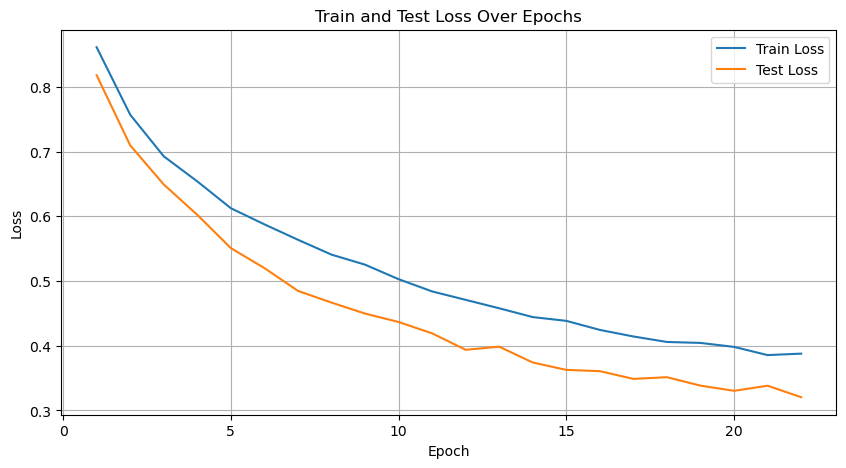

Epoch: 22
---------
Train Loss of [Batch 0/385]: 0.3345
Train Loss of [Batch 100/385]: 0.4308
Train Loss of [Batch 200/385]: 0.2803
Train Loss of [Batch 300/385]: 0.4196

Train loss: 0.38098 | Train accuracy: 90.09%
Train Class-wise Loss: tensor([0.4176, 0.3343], device='cuda:0')

Test loss: 0.31422 | Test accuracy: 85.09%
Test Class-wise Loss: tensor([0.5112, 0.2491], device='cuda:0')



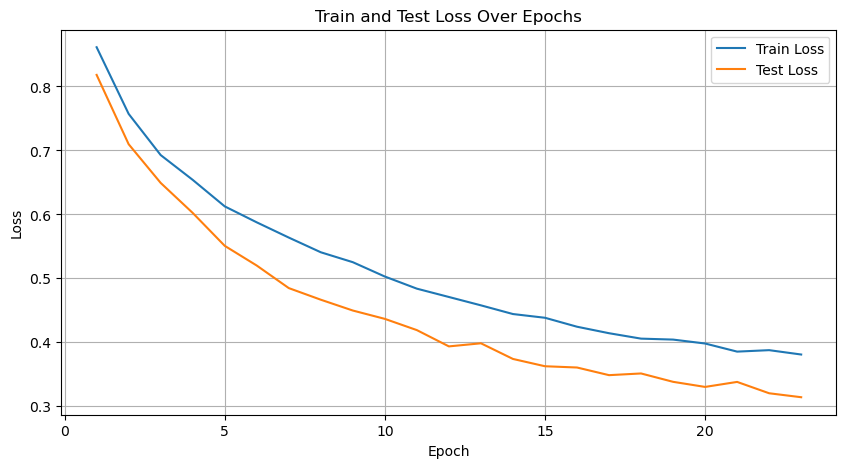

Epoch: 23
---------
Train Loss of [Batch 0/385]: 0.5292
Train Loss of [Batch 100/385]: 0.3141
Train Loss of [Batch 200/385]: 0.4104
Train Loss of [Batch 300/385]: 0.3208

Train loss: 0.37394 | Train accuracy: 90.12%
Train Class-wise Loss: tensor([0.4085, 0.3394], device='cuda:0')

Test loss: 0.31558 | Test accuracy: 83.79%
Test Class-wise Loss: tensor([0.5374, 0.2344], device='cuda:0')



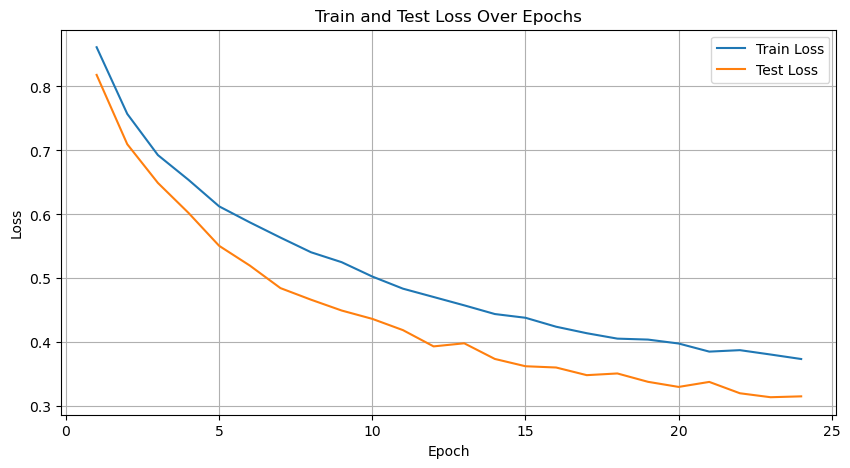

Epoch: 24
---------
Train Loss of [Batch 0/385]: 0.3000
Train Loss of [Batch 100/385]: 0.3143
Train Loss of [Batch 200/385]: 0.3944
Train Loss of [Batch 300/385]: 0.2928

Train loss: 0.36692 | Train accuracy: 90.17%
Train Class-wise Loss: tensor([0.4005, 0.3262], device='cuda:0')

Test loss: 0.31030 | Test accuracy: 84.05%
Test Class-wise Loss: tensor([0.5401, 0.2256], device='cuda:0')



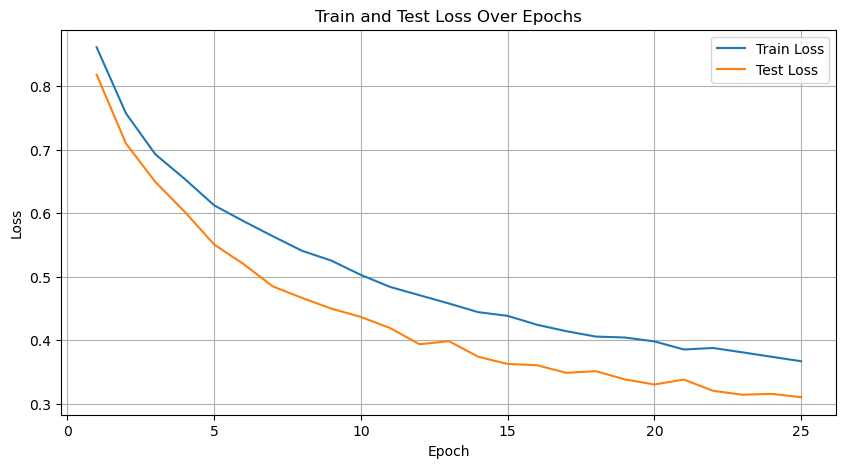

Epoch: 25
---------
Train Loss of [Batch 0/385]: 0.4040
Train Loss of [Batch 100/385]: 0.3754
Train Loss of [Batch 200/385]: 0.3854
Train Loss of [Batch 300/385]: 0.3031

Train loss: 0.36494 | Train accuracy: 90.29%
Train Class-wise Loss: tensor([0.3923, 0.3345], device='cuda:0')

Test loss: 0.30351 | Test accuracy: 85.16%
Test Class-wise Loss: tensor([0.4875, 0.2544], device='cuda:0')



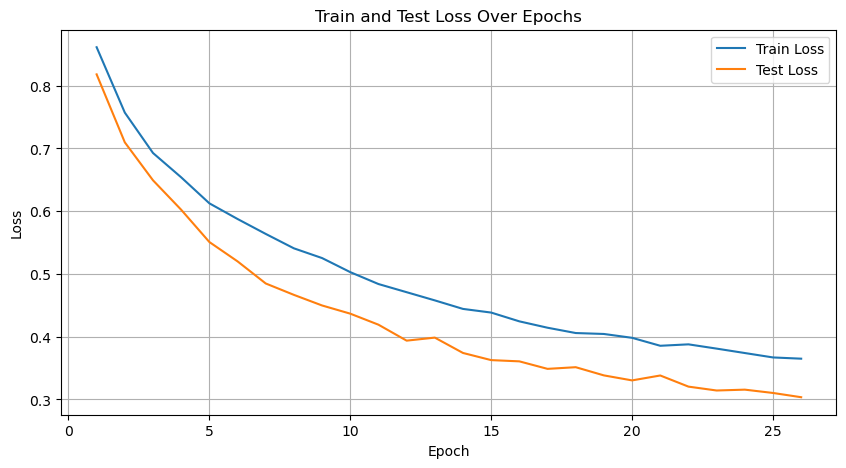

Epoch: 26
---------
Train Loss of [Batch 0/385]: 0.3260
Train Loss of [Batch 100/385]: 0.3367
Train Loss of [Batch 200/385]: 0.2858
Train Loss of [Batch 300/385]: 0.2525

Train loss: 0.36291 | Train accuracy: 90.20%
Train Class-wise Loss: tensor([0.3877, 0.3420], device='cuda:0')

Test loss: 0.30242 | Test accuracy: 84.24%
Test Class-wise Loss: tensor([0.5141, 0.2295], device='cuda:0')



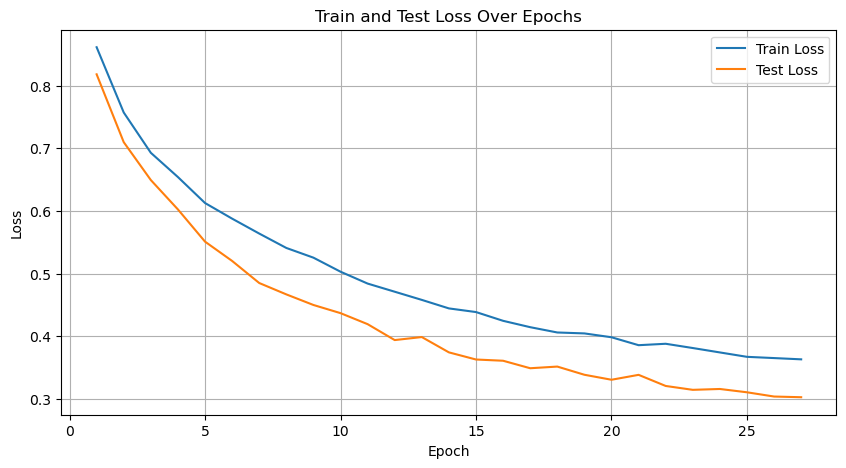

Epoch: 27
---------
Train Loss of [Batch 0/385]: 0.3797
Train Loss of [Batch 100/385]: 0.4518
Train Loss of [Batch 200/385]: 0.3157
Train Loss of [Batch 300/385]: 0.3514

Train loss: 0.35776 | Train accuracy: 90.20%
Train Class-wise Loss: tensor([0.3817, 0.3372], device='cuda:0')

Test loss: 0.29625 | Test accuracy: 84.69%
Test Class-wise Loss: tensor([0.4969, 0.2338], device='cuda:0')



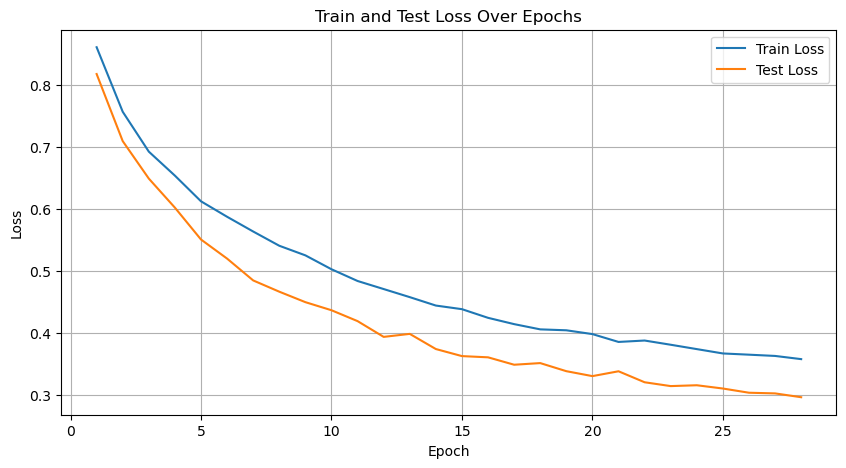

Epoch: 28
---------
Train Loss of [Batch 0/385]: 0.5232
Train Loss of [Batch 100/385]: 0.3132
Train Loss of [Batch 200/385]: 0.3997
Train Loss of [Batch 300/385]: 0.3497

Train loss: 0.35397 | Train accuracy: 90.38%
Train Class-wise Loss: tensor([0.3741, 0.3347], device='cuda:0')

Test loss: 0.29460 | Test accuracy: 85.53%
Test Class-wise Loss: tensor([0.4687, 0.2528], device='cuda:0')



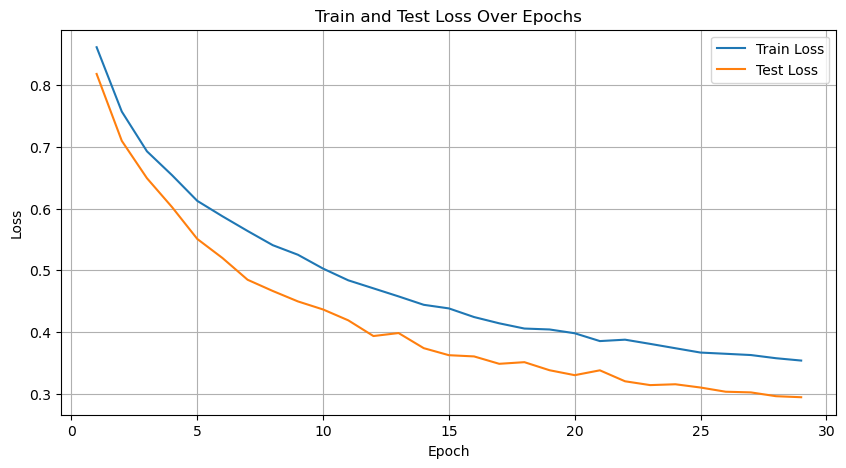

Epoch: 29
---------
Train Loss of [Batch 0/385]: 0.3199
Train Loss of [Batch 100/385]: 0.3105
Train Loss of [Batch 200/385]: 0.2815
Train Loss of [Batch 300/385]: 0.2712

Train loss: 0.35070 | Train accuracy: 90.51%
Train Class-wise Loss: tensor([0.3669, 0.3319], device='cuda:0')

Test loss: 0.29117 | Test accuracy: 84.78%
Test Class-wise Loss: tensor([0.4861, 0.2354], device='cuda:0')



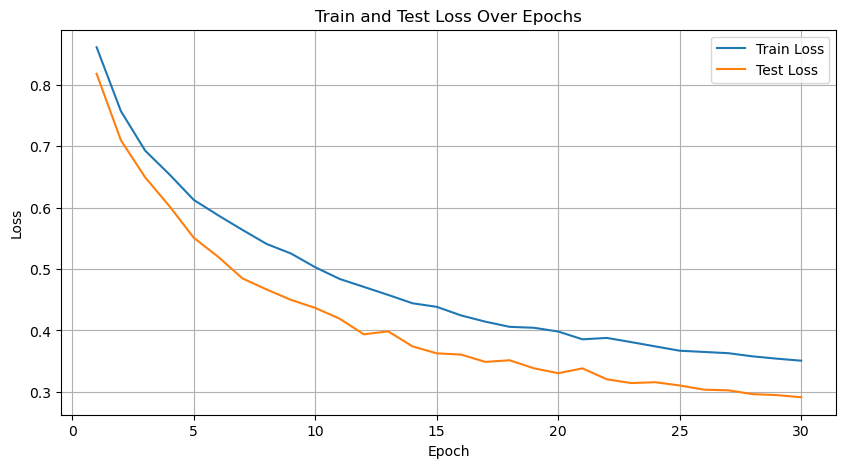

Epoch: 30
---------
Train Loss of [Batch 0/385]: 0.3494
Train Loss of [Batch 100/385]: 0.3076
Train Loss of [Batch 200/385]: 0.4785
Train Loss of [Batch 300/385]: 0.3236

Train loss: 0.34777 | Train accuracy: 90.43%
Train Class-wise Loss: tensor([0.3633, 0.3380], device='cuda:0')

Test loss: 0.28965 | Test accuracy: 85.89%
Test Class-wise Loss: tensor([0.4475, 0.2644], device='cuda:0')



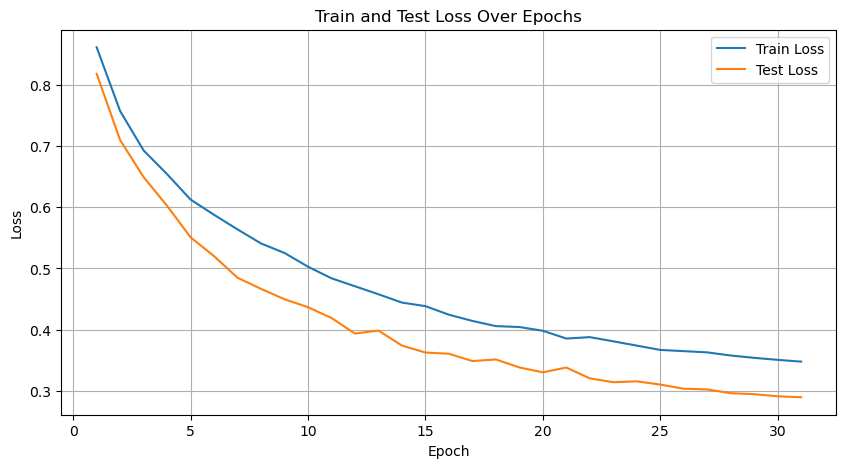

Epoch: 31
---------
Train Loss of [Batch 0/385]: 0.4239
Train Loss of [Batch 100/385]: 0.6393
Train Loss of [Batch 200/385]: 0.3164
Train Loss of [Batch 300/385]: 0.2902

Train loss: 0.34571 | Train accuracy: 90.42%
Train Class-wise Loss: tensor([0.3596, 0.3349], device='cuda:0')

Test loss: 0.28947 | Test accuracy: 84.62%
Test Class-wise Loss: tensor([0.4756, 0.2445], device='cuda:0')



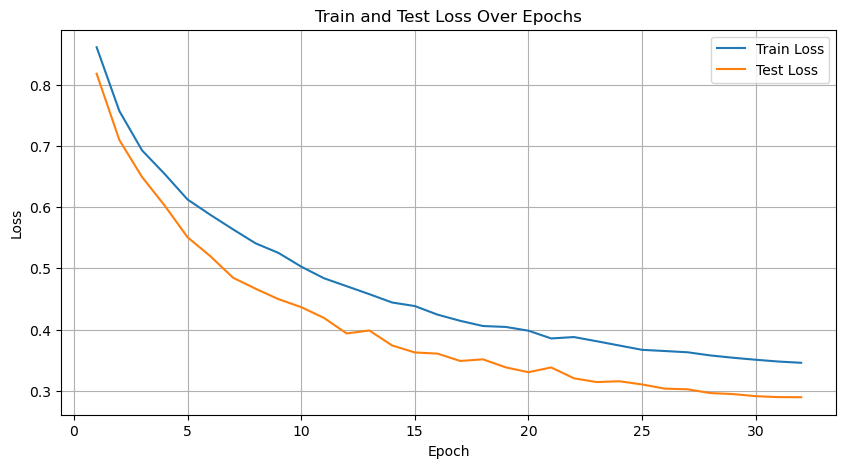

Epoch: 32
---------
Train Loss of [Batch 0/385]: 0.3640
Train Loss of [Batch 100/385]: 0.3663
Train Loss of [Batch 200/385]: 0.3054
Train Loss of [Batch 300/385]: 0.2999

Train loss: 0.33839 | Train accuracy: 90.61%
Train Class-wise Loss: tensor([0.3515, 0.3391], device='cuda:0')

Test loss: 0.29233 | Test accuracy: 83.09%
Test Class-wise Loss: tensor([0.5223, 0.2102], device='cuda:0')



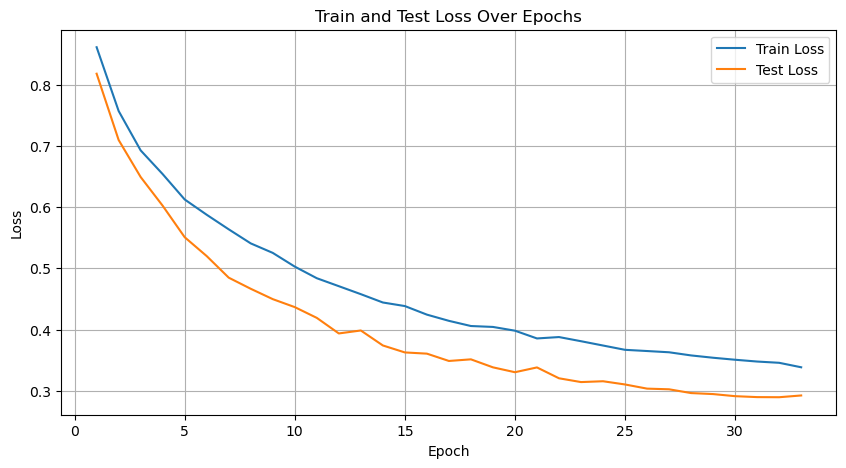

Epoch: 33
---------
Train Loss of [Batch 0/385]: 0.5579
Train Loss of [Batch 100/385]: 0.3639
Train Loss of [Batch 200/385]: 0.2583
Train Loss of [Batch 300/385]: 0.3611

Train loss: 0.33674 | Train accuracy: 90.79%
Train Class-wise Loss: tensor([0.3466, 0.3333], device='cuda:0')

Test loss: 0.28163 | Test accuracy: 84.66%
Test Class-wise Loss: tensor([0.4727, 0.2341], device='cuda:0')



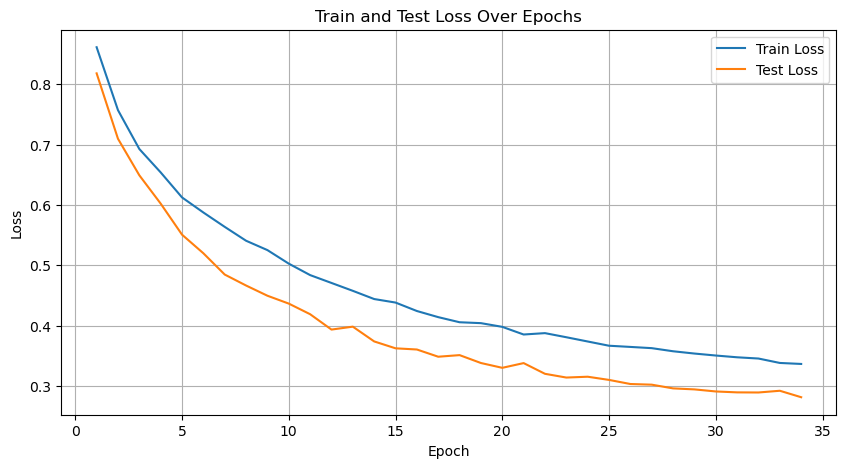

Epoch: 34
---------
Train Loss of [Batch 0/385]: 0.3560
Train Loss of [Batch 100/385]: 0.3230
Train Loss of [Batch 200/385]: 0.2520
Train Loss of [Batch 300/385]: 0.2824

Train loss: 0.33510 | Train accuracy: 90.67%
Train Class-wise Loss: tensor([0.3433, 0.3302], device='cuda:0')

Test loss: 0.27912 | Test accuracy: 85.46%
Test Class-wise Loss: tensor([0.4480, 0.2511], device='cuda:0')



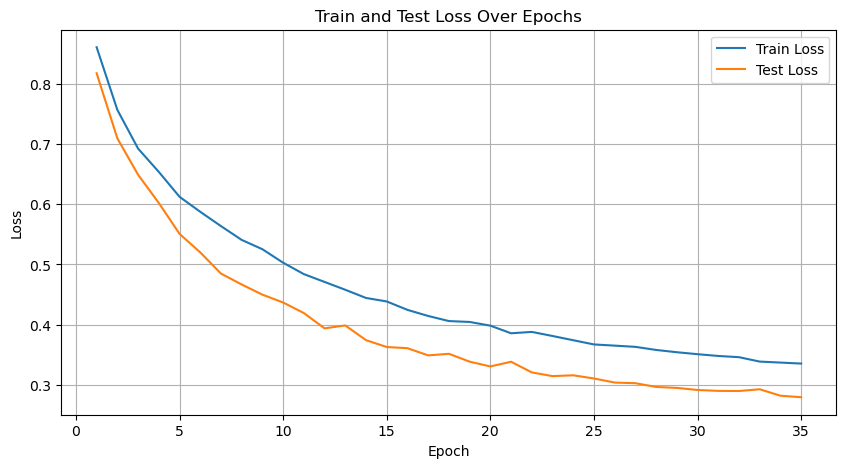

Epoch: 35
---------
Train Loss of [Batch 0/385]: 0.3036
Train Loss of [Batch 100/385]: 0.3907
Train Loss of [Batch 200/385]: 0.4239
Train Loss of [Batch 300/385]: 0.3111

Train loss: 0.33060 | Train accuracy: 90.83%
Train Class-wise Loss: tensor([0.3364, 0.3265], device='cuda:0')

Test loss: 0.27463 | Test accuracy: 87.71%
Test Class-wise Loss: tensor([0.3879, 0.2932], device='cuda:0')



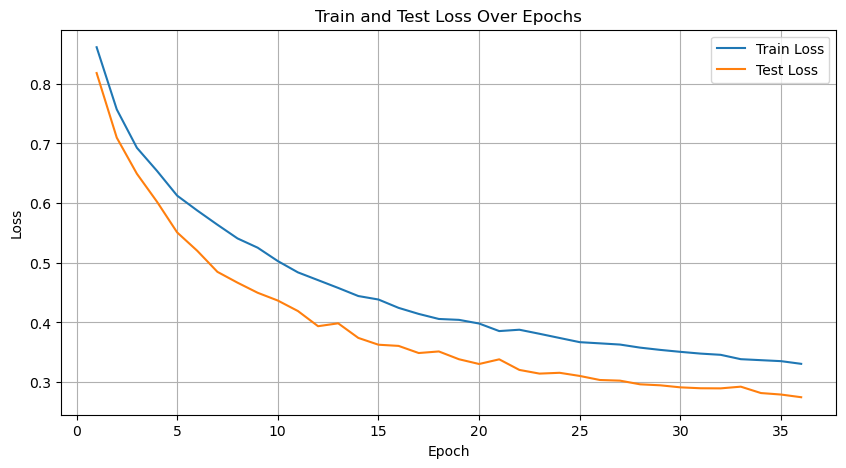

Epoch: 36
---------
Train Loss of [Batch 0/385]: 0.3007
Train Loss of [Batch 100/385]: 0.3755
Train Loss of [Batch 200/385]: 0.3099
Train Loss of [Batch 300/385]: 0.3901

Train loss: 0.33274 | Train accuracy: 90.87%
Train Class-wise Loss: tensor([0.3331, 0.3463], device='cuda:0')

Test loss: 0.27657 | Test accuracy: 84.73%
Test Class-wise Loss: tensor([0.4629, 0.2336], device='cuda:0')



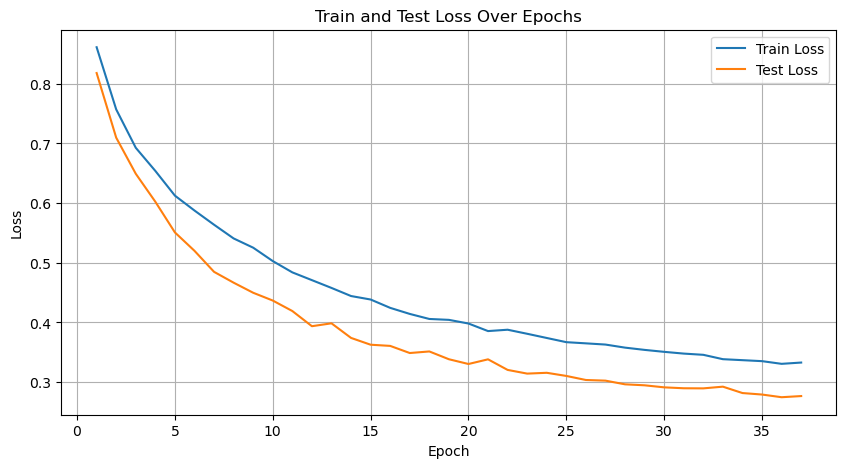

Epoch: 37
---------
Train Loss of [Batch 0/385]: 0.3355
Train Loss of [Batch 100/385]: 0.3733
Train Loss of [Batch 200/385]: 0.2945
Train Loss of [Batch 300/385]: 0.3157

Train loss: 0.32579 | Train accuracy: 90.87%
Train Class-wise Loss: tensor([0.3287, 0.3345], device='cuda:0')

Test loss: 0.27544 | Test accuracy: 85.47%
Test Class-wise Loss: tensor([0.4376, 0.2583], device='cuda:0')



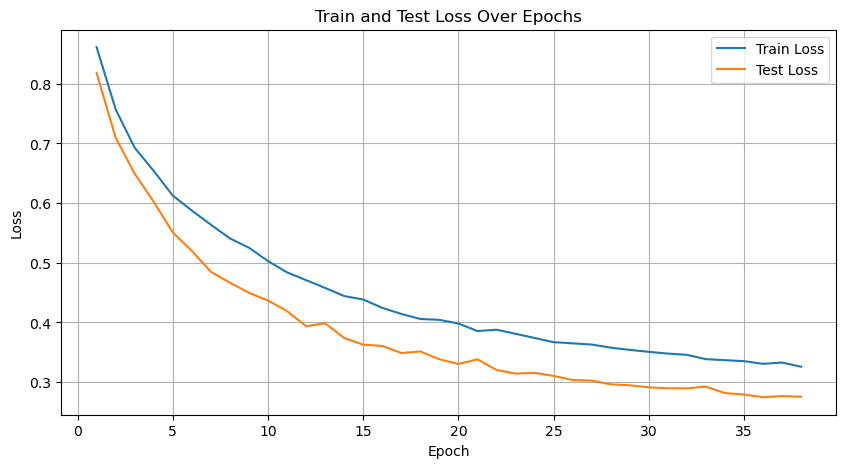

Epoch: 38
---------
Train Loss of [Batch 0/385]: 0.2575
Train Loss of [Batch 100/385]: 0.2694
Train Loss of [Batch 200/385]: 0.3399
Train Loss of [Batch 300/385]: 0.2889

Train loss: 0.32332 | Train accuracy: 90.90%
Train Class-wise Loss: tensor([0.3267, 0.3289], device='cuda:0')

Test loss: 0.27296 | Test accuracy: 86.11%
Test Class-wise Loss: tensor([0.4173, 0.2691], device='cuda:0')



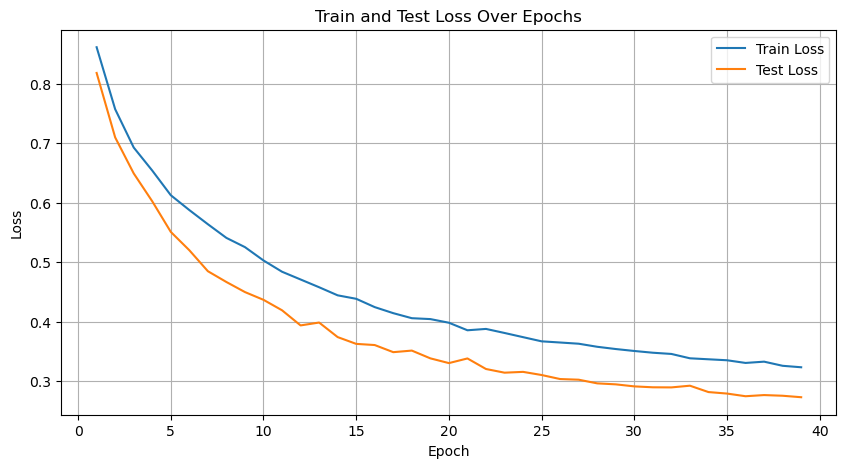

Epoch: 39
---------
Train Loss of [Batch 0/385]: 0.3435
Train Loss of [Batch 100/385]: 0.1747
Train Loss of [Batch 200/385]: 0.2785
Train Loss of [Batch 300/385]: 0.4406

Train loss: 0.32788 | Train accuracy: 90.78%
Train Class-wise Loss: tensor([0.3252, 0.3397], device='cuda:0')

Test loss: 0.26960 | Test accuracy: 86.10%
Test Class-wise Loss: tensor([0.4139, 0.2602], device='cuda:0')



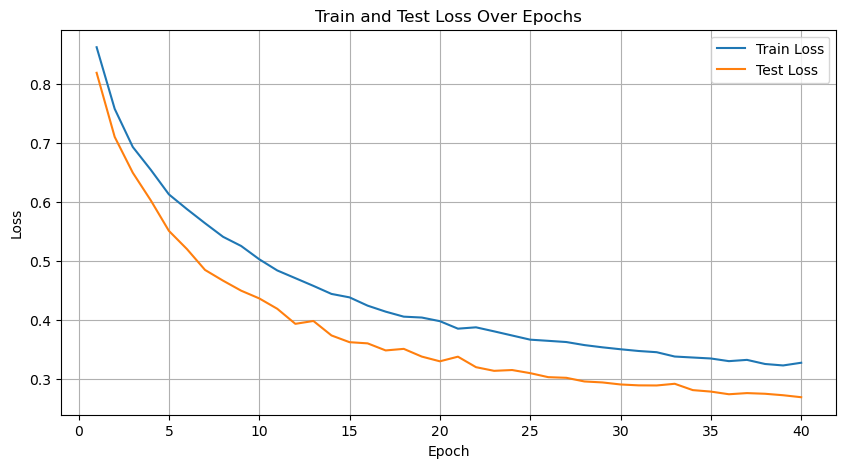

Epoch: 40
---------
Train Loss of [Batch 0/385]: 0.1839
Train Loss of [Batch 100/385]: 0.3475
Train Loss of [Batch 200/385]: 0.2693
Train Loss of [Batch 300/385]: 0.2303

Train loss: 0.32184 | Train accuracy: 90.98%
Train Class-wise Loss: tensor([0.3190, 0.3292], device='cuda:0')

Test loss: 0.27019 | Test accuracy: 85.92%
Test Class-wise Loss: tensor([0.4160, 0.2633], device='cuda:0')



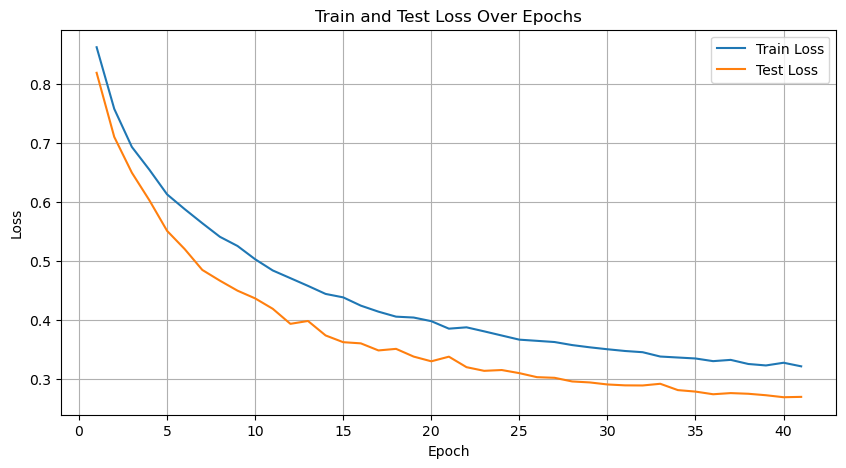

Epoch: 41
---------
Train Loss of [Batch 0/385]: 0.3445
Train Loss of [Batch 100/385]: 0.2456
Train Loss of [Batch 200/385]: 0.2960
Train Loss of [Batch 300/385]: 0.3519

Train loss: 0.31861 | Train accuracy: 91.07%
Train Class-wise Loss: tensor([0.3148, 0.3306], device='cuda:0')

Test loss: 0.26602 | Test accuracy: 87.28%
Test Class-wise Loss: tensor([0.3849, 0.2826], device='cuda:0')



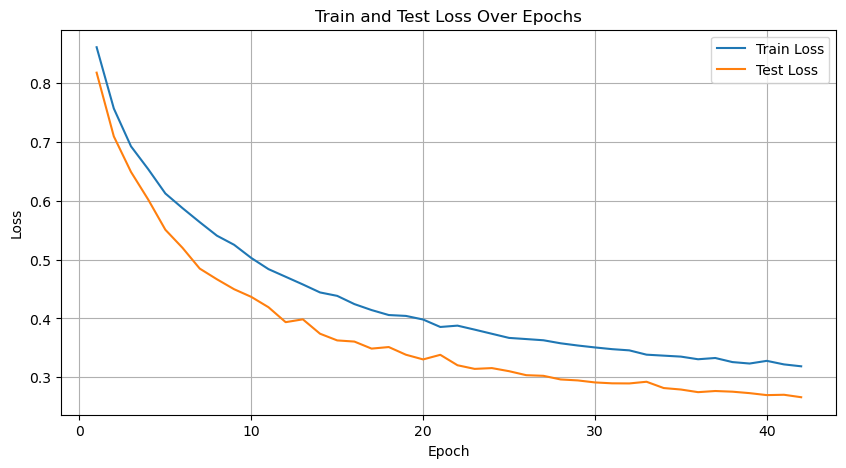

Epoch: 42
---------
Train Loss of [Batch 0/385]: 0.2536
Train Loss of [Batch 100/385]: 0.3141
Train Loss of [Batch 200/385]: 0.2795
Train Loss of [Batch 300/385]: 0.3186

Train loss: 0.31907 | Train accuracy: 90.97%
Train Class-wise Loss: tensor([0.3142, 0.3361], device='cuda:0')

Test loss: 0.26409 | Test accuracy: 87.61%
Test Class-wise Loss: tensor([0.3784, 0.2845], device='cuda:0')



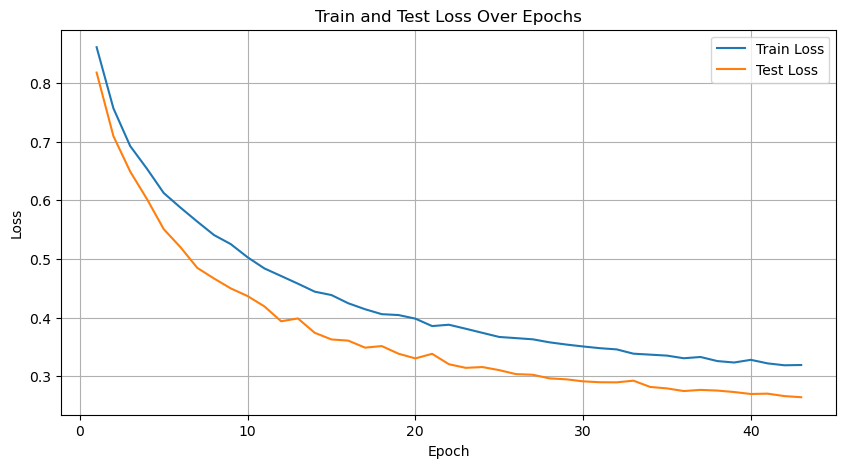

Epoch: 43
---------
Train Loss of [Batch 0/385]: 0.4247
Train Loss of [Batch 100/385]: 0.2492
Train Loss of [Batch 200/385]: 0.3100
Train Loss of [Batch 300/385]: 0.3746

Train loss: 0.31704 | Train accuracy: 91.03%
Train Class-wise Loss: tensor([0.3104, 0.3337], device='cuda:0')

Test loss: 0.26109 | Test accuracy: 87.84%
Test Class-wise Loss: tensor([0.3706, 0.2924], device='cuda:0')



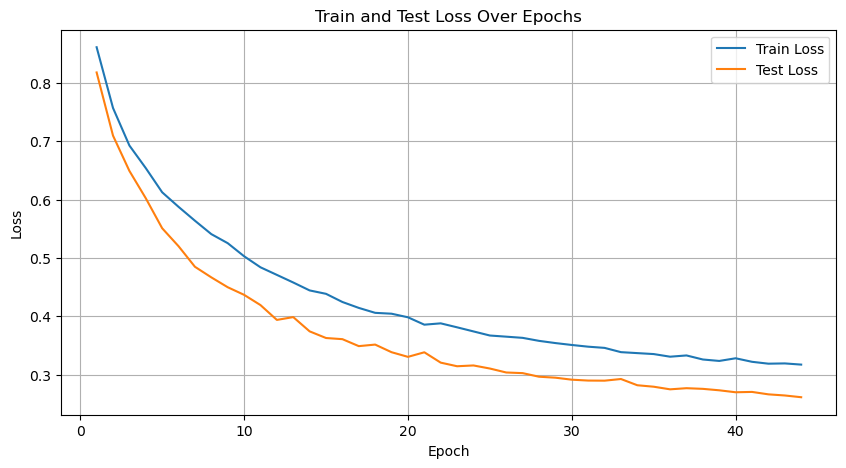

Epoch: 44
---------
Train Loss of [Batch 0/385]: 0.3973
Train Loss of [Batch 100/385]: 0.1788
Train Loss of [Batch 200/385]: 0.2663
Train Loss of [Batch 300/385]: 0.2386

Train loss: 0.31705 | Train accuracy: 91.13%
Train Class-wise Loss: tensor([0.3075, 0.3425], device='cuda:0')

Test loss: 0.26152 | Test accuracy: 86.50%
Test Class-wise Loss: tensor([0.4084, 0.2562], device='cuda:0')



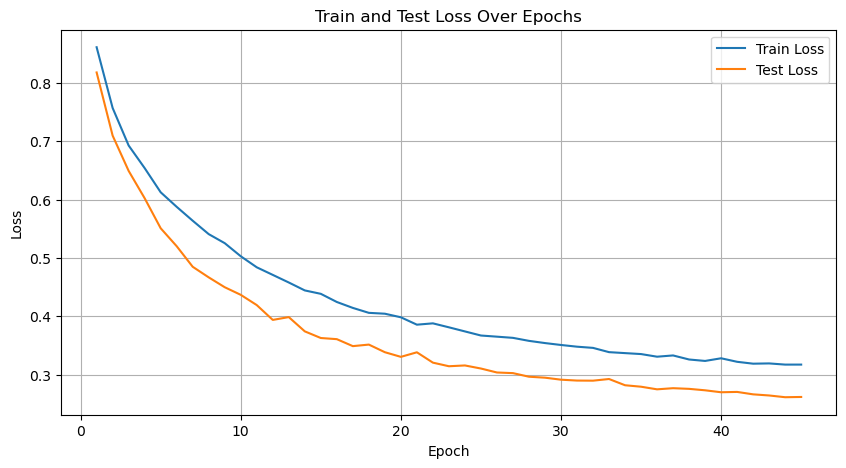

Epoch: 45
---------
Train Loss of [Batch 0/385]: 0.5690
Train Loss of [Batch 100/385]: 0.2528
Train Loss of [Batch 200/385]: 0.2591
Train Loss of [Batch 300/385]: 0.2212

Train loss: 0.31288 | Train accuracy: 91.37%
Train Class-wise Loss: tensor([0.3031, 0.3303], device='cuda:0')

Test loss: 0.26003 | Test accuracy: 86.69%
Test Class-wise Loss: tensor([0.4012, 0.2579], device='cuda:0')



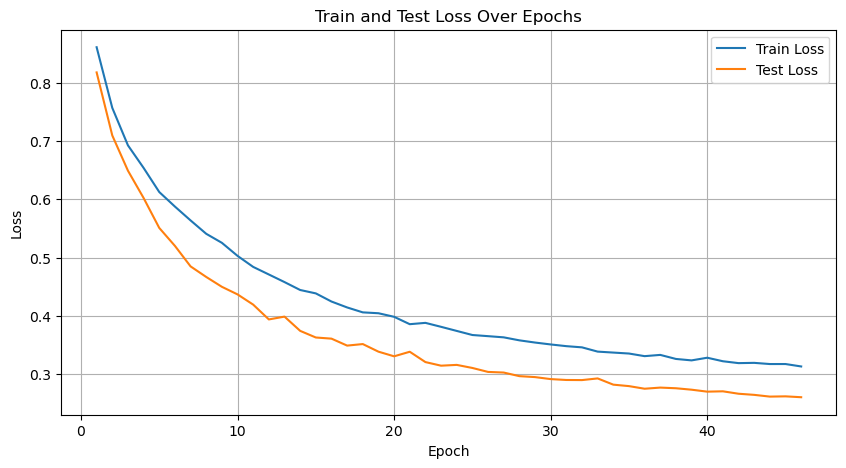

Epoch: 46
---------
Train Loss of [Batch 0/385]: 0.2731
Train Loss of [Batch 100/385]: 0.2978
Train Loss of [Batch 200/385]: 0.2267
Train Loss of [Batch 300/385]: 0.3459

Train loss: 0.31278 | Train accuracy: 91.36%
Train Class-wise Loss: tensor([0.3014, 0.3393], device='cuda:0')

Test loss: 0.25895 | Test accuracy: 86.07%
Test Class-wise Loss: tensor([0.4122, 0.2494], device='cuda:0')



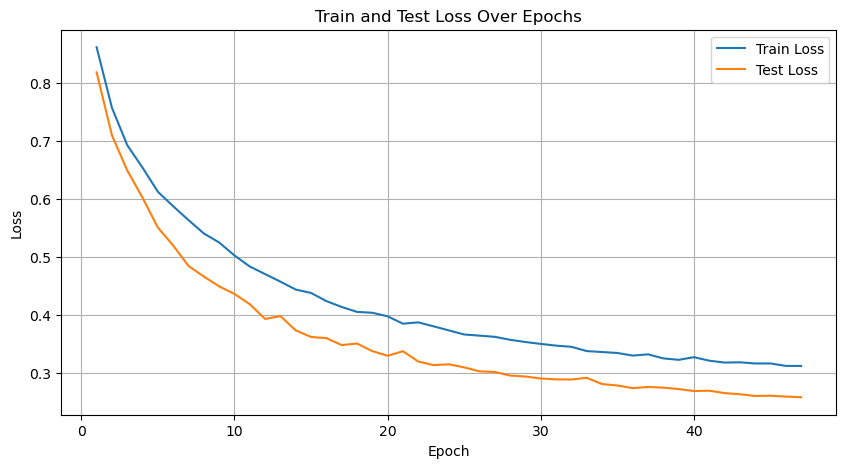

Epoch: 47
---------
Train Loss of [Batch 0/385]: 0.2599
Train Loss of [Batch 100/385]: 0.2705
Train Loss of [Batch 200/385]: 0.2655
Train Loss of [Batch 300/385]: 0.3886

Train loss: 0.30660 | Train accuracy: 91.37%
Train Class-wise Loss: tensor([0.2982, 0.3197], device='cuda:0')

Test loss: 0.25671 | Test accuracy: 87.42%
Test Class-wise Loss: tensor([0.3774, 0.2710], device='cuda:0')



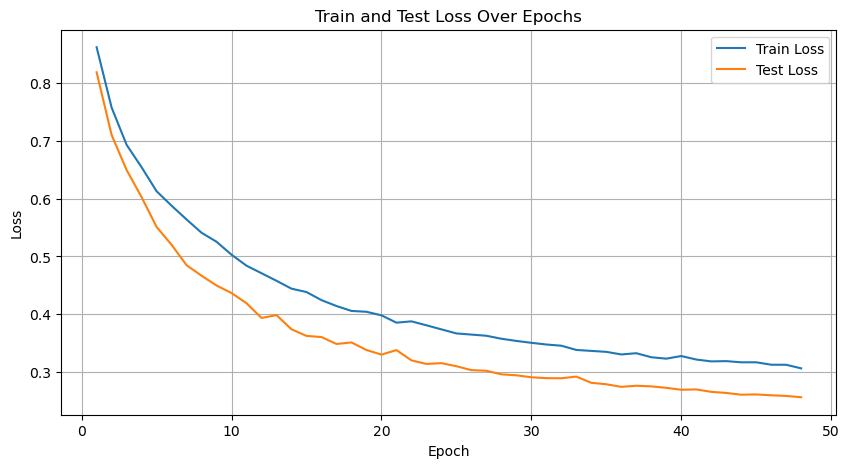

Epoch: 48
---------
Train Loss of [Batch 0/385]: 0.2502
Train Loss of [Batch 100/385]: 0.2680
Train Loss of [Batch 200/385]: 0.2221
Train Loss of [Batch 300/385]: 0.3445

Train loss: 0.30564 | Train accuracy: 91.37%
Train Class-wise Loss: tensor([0.2976, 0.3277], device='cuda:0')

Test loss: 0.25648 | Test accuracy: 87.87%
Test Class-wise Loss: tensor([0.3638, 0.2857], device='cuda:0')



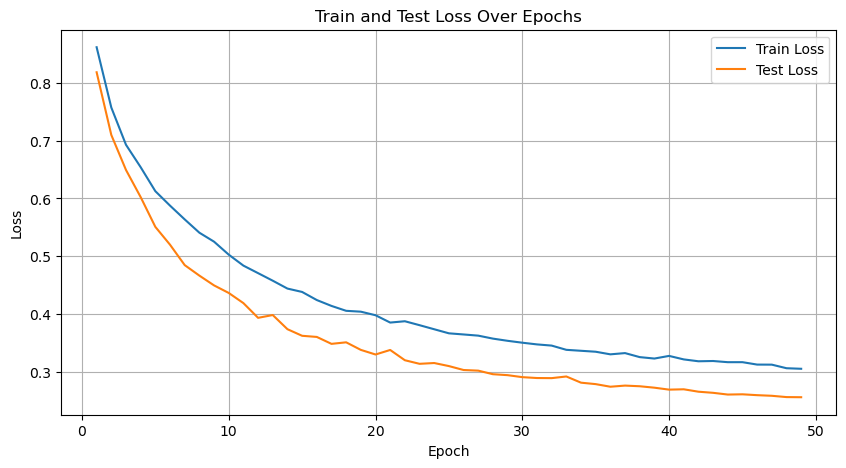

Epoch: 49
---------
Train Loss of [Batch 0/385]: 0.3608
Train Loss of [Batch 100/385]: 0.2792
Train Loss of [Batch 200/385]: 0.2772
Train Loss of [Batch 300/385]: 0.3158

Train loss: 0.30989 | Train accuracy: 91.38%
Train Class-wise Loss: tensor([0.2934, 0.3397], device='cuda:0')

Test loss: 0.25600 | Test accuracy: 87.71%
Test Class-wise Loss: tensor([0.3669, 0.2828], device='cuda:0')



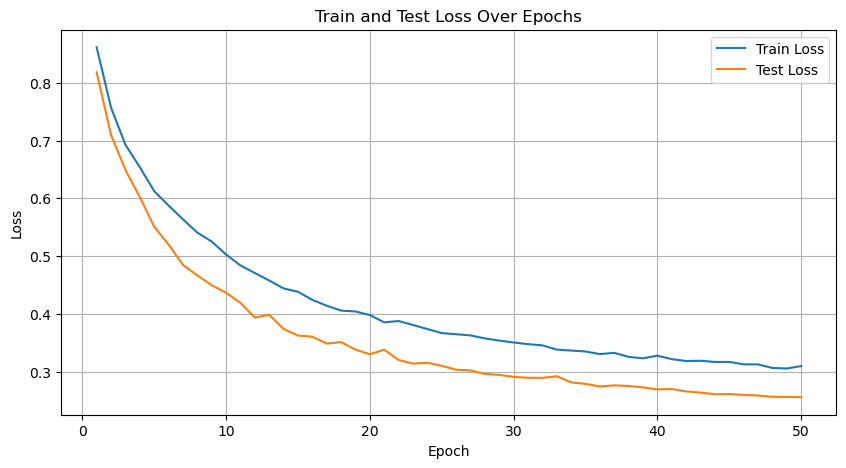

Train time on cuda: 13846.952 seconds


In [ ]:
from tqdm.auto import tqdm

# Fix random seed for reproducibility
torch.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.cuda.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Learning rate:", configs_sc.HYPERPARAMETERS["learning_rate"])
print("Number of epochs:", configs_sc.HYPERPARAMETERS["epochs"])

# measure time with timing function
from timeit import default_timer as timer
start = timer()

# empty lists for storing of evaluation metrics
train_loss_progress = []
test_loss_progress = []
train_class_wise_losses = []
test_class_wise_losses = []

# epoch loop
for epoch in tqdm(range(configs_sc.HYPERPARAMETERS["epochs"])):
    print(f"Epoch: {epoch}\n---------") # print current epoch

    train_loss_epoch, train_class_wise_loss = train_utils.train_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    train_loss_progress.append({"epoch": epoch + 1, "train loss": train_loss_epoch})
    train_class_wise_losses.append(train_class_wise_loss.cpu().numpy())  # change to numpy for easier plotting

    test_loss_epoch, test_class_wise_loss = train_utils.test_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=test_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_loss_progress.append({"epoch": epoch + 1, "test loss": test_loss_epoch})
    test_class_wise_losses.append(test_class_wise_loss.cpu().numpy())


    # Clear output and update plot
    epochs = [entry["epoch"] for entry in train_loss_progress]
    train_losses = [entry["train loss"] for entry in train_loss_progress]
    test_losses = [entry["test loss"].cpu().item() for entry in test_loss_progress]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Train Cross Entropy Loss")
    plt.plot(epochs, test_losses, label="Test Cross Entropy Loss")
    plt.xlabel("Epoch []")
    plt.ylabel("Cross Entropy Loss []")
    plt.title("Train and Test Cross Entropy Loss Over Epochs")
    plt.xlim(left=0) # Force x-axis to start at epoch 0
    plt.ylim(bottom=0) # Force y-axis to start at 0
    plt.legend()
    plt.grid(True)
    plt.show()



end = timer()
train_utils.print_train_time(start, end, device)

**VISUALIZE!**

In [3]:
# Plot train class-wise loss of a specific epoch
# ADJUSTABLE!
# try_epoch = 2
# visualization_utils.plot_classwise_loss(try_epoch, train_class_wise_losses, configs_sc.HYPERPARAMETERS["num_classes"])

In [4]:
# Plot test class-wise loss of a specific epoch
# visualization_utils.plot_classwise_loss(try_epoch, test_class_wise_losses, configs_sc.HYPERPARAMETERS["num_classes"])

In [ ]:
# Plot the train loss curves per class

# Create a list of epoch numbers based on the number of entries in train_class_wise_losses
epochs = list(range(1, len(train_class_wise_losses) + 1))

# Extract the loss for class 0 and class 1 for each epoch.
# Here, we assume that each entry in train_class_wise_losses is a tuple or array like [loss_class0, loss_class1, ...].
class0_losses = [losses[0] for losses in train_class_wise_losses]
class1_losses = [losses[1] for losses in train_class_wise_losses]
class2_losses = [losses[2] for losses in train_class_wise_losses]
class3_losses = [losses[3] for losses in train_class_wise_losses]
class4_losses = [losses[4] for losses in train_class_wise_losses]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, class0_losses, marker='o', linestyle='-', label="Loss Class 0: background")
plt.plot(epochs, class1_losses, marker='o', linestyle='-', label="Loss Class 1: woody debris")
plt.plot(epochs, class2_losses, marker='o', linestyle='-', label="Loss Class 2: rootstock")
plt.plot(epochs, class3_losses, marker='o', linestyle='-', label="Loss Class 3: sand/mud bar")
plt.plot(epochs, class4_losses, marker='o', linestyle='-', label="Loss Class 4: gravel bar")
plt.xlabel("Epoch []")                          # Set the x-axis label
plt.ylabel("Cross Entropy Loss []")                           # Set the y-axis label
plt.title("Training Loss per Class over Epochs")  # Set the plot title
plt.xlim(left=0)                              # Force x-axis to start at epoch 0
plt.ylim(bottom=0)                            # Force y-axis to start at 0
plt.legend()                                 # Display the legend
plt.grid(True)                               # Enable grid for better readability
plt.show()                                   # Display the plot

NameError: name 'train_class_wise_losses' is not defined

In [ ]:
# Plot the test loss curves per class

# Create a list of epoch numbers based on the number of entries in train_class_wise_losses
epochs = list(range(1, len(test_class_wise_losses) + 1))

# Extract the loss for class 0 and class 1 for each epoch.
# Here, we assume that each entry in train_class_wise_losses is a tuple or array like [loss_class0, loss_class1, ...].
class0_losses = [losses[0] for losses in test_class_wise_losses]
class1_losses = [losses[1] for losses in test_class_wise_losses]
class2_losses = [losses[2] for losses in test_class_wise_losses]
class3_losses = [losses[3] for losses in test_class_wise_losses]
class4_losses = [losses[4] for losses in test_class_wise_losses]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, class0_losses, marker='o', linestyle='-', label="Loss Class 0: background")
plt.plot(epochs, class1_losses, marker='o', linestyle='-', label="Loss Class 1: woody debris")
plt.plot(epochs, class2_losses, marker='o', linestyle='-', label="Loss Class 2: rootstock")
plt.plot(epochs, class3_losses, marker='o', linestyle='-', label="Loss Class 3: sand/mud bar")
plt.plot(epochs, class4_losses, marker='o', linestyle='-', label="Loss Class 4: gravel bar")
plt.xlabel("Epoch []")                          # Set the x-axis label
plt.ylabel(" Cross Entropy Loss []")                           # Set the y-axis label
plt.title("Test Loss per Class over Epochs")  # Set the plot title
plt.xlim(left=0)                              # Force x-axis to start at epoch 0
plt.ylim(bottom=0)                            # Force y-axis to start at 0
plt.legend()                                 # Display the legend
plt.grid(True)                               # Enable grid for better readability
plt.show()                                   # Display the plot

NameError: name 'test_class_wise_losses' is not defined

## 5. Save and load trained model

1. Create individual name of the trained

In [ ]:
# Create INDIVIDUAL model name and add to corresponding path

# counter for model version
counter = 1

# function for generating initial model name
def generate_model_name(base_name, epochs, counter):
    return f"{base_name}_{epochs}_{counter}.pth"

base_name = "unet_model_5class_NOdataaugmentation"

# generate initial name and path
MODEL_NAME = generate_model_name(base_name, configs_sc.HYPERPARAMETERS["epochs"], counter)
save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

# check if there is already a model saved with the same name -> if so: increase the counter
while os.path.exists(save_model_path):
    print(f"Warning: File with name {MODEL_NAME} already exists. Increase the counter...")
    counter += 1
    MODEL_NAME = generate_model_name(base_name, configs_sc.HYPERPARAMETERS["epochs"], counter)
    save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

2. Save the models state dict

In [ ]:
# Save the models state dict
print(f"Saving model to: {save_model_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=save_model_path)

Saving model to: /home/sc.uni-leipzig.de/rf37uqip/MoSE/saved_models/unet_model_2classes_dataaugmentation_50_1.pth


In [ ]:
# save important variables

import pickle

# Create a dictionary with your metrics
metrics = {
    "train_loss_progress": train_loss_progress,
    "test_loss_progress": test_loss_progress,
    "train_class_wise_losses": train_class_wise_losses,
    "test_class_wise_losses": test_class_wise_losses
}

# Save the metrics to a file using pickle
with open("metrics_unet_model_5class_NOdataaugmentation_50.pkl", "wb") as f:
    pickle.dump(metrics, f)

print("Metrics have been saved!")

In [ ]:
with open("metrics_unet_model_5class_NOdataaugmentation_50.pkl", "rb") as f:
    loaded_metrics = pickle.load(f)

**3. Load the model**

In [ ]:
# Load the model

#######
MODEL_NAME = "unet_model_5class_NOdataaugmentation_50_1.pth" # ---------> ADJUSTABLE!
#######
save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

# Create a new instance of the model (same class as our saved state_dict())
loaded_model = model_utils.model_0.to(device)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=save_model_path, weights_only=True))

# Send model to GPU
loaded_model = loaded_model.to(device)

## 6. Evaluate trained model

Make predictions for the entire test data set with the trained model and display the results in a confusion matrix.

### 6.1 Confusion Matrix, Accuracies and F1-Scores
Confusion Matrix for entire test data set!

Test accuracy: 87.71%

Test class-wise accuracies: [0.8768157360520374, 0.8932073650738215]



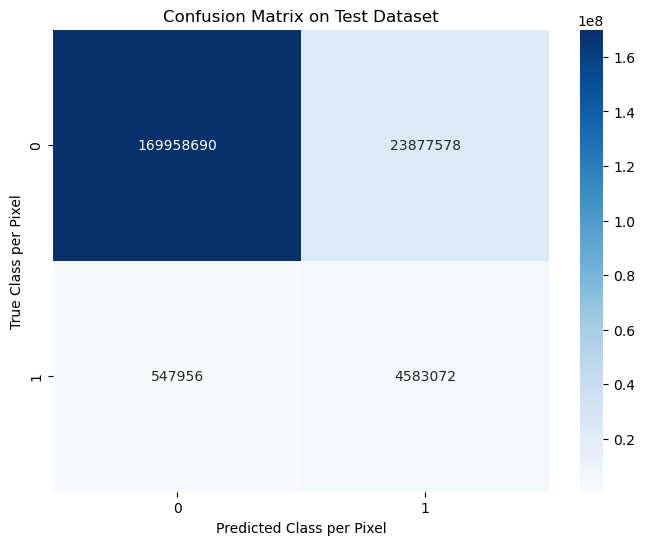

Class-wise evaluation metrics:
   Class  Precision  Recall  F1-Score
0      0     0.9968  0.8768    0.9330
1      1     0.1610  0.8932    0.2729

Macro Precision: 0.5789
Macro Recall: 0.885
Macro F1-Score: 0.6029


In [59]:
# predictions for entire test data set
evaluation_utils.evaluate_model_with_testdata(loaded_model, test_loader, accuracy_fn, configs_sc.HYPERPARAMETERS["num_classes"], device, F1_analysis = True)

Confusion Matrix, Accuracies and F1-Scores for a part of the test data set!

In [73]:
# predictions for a part of the test data set
# from torch.utils.data import Subset

# # use only __ patch(es) of the test data set
# subset_indices = range(100)  # indices of sample test data set
# subset_test_data = Subset(test_loader.dataset, subset_indices)


# # create subset of test_loader
# subset_test_loader = DataLoader(subset_test_data, batch_size=test_loader.batch_size, shuffle=False)

# evaluation_utils.evaluate_model_with_testdata(
#     loaded_model, subset_test_loader, accuracy_fn, 
#     configs_sc.HYPERPARAMETERS["num_classes"], device, 
#     F1_analysis = True)

### 6.2 Visual Evaluation

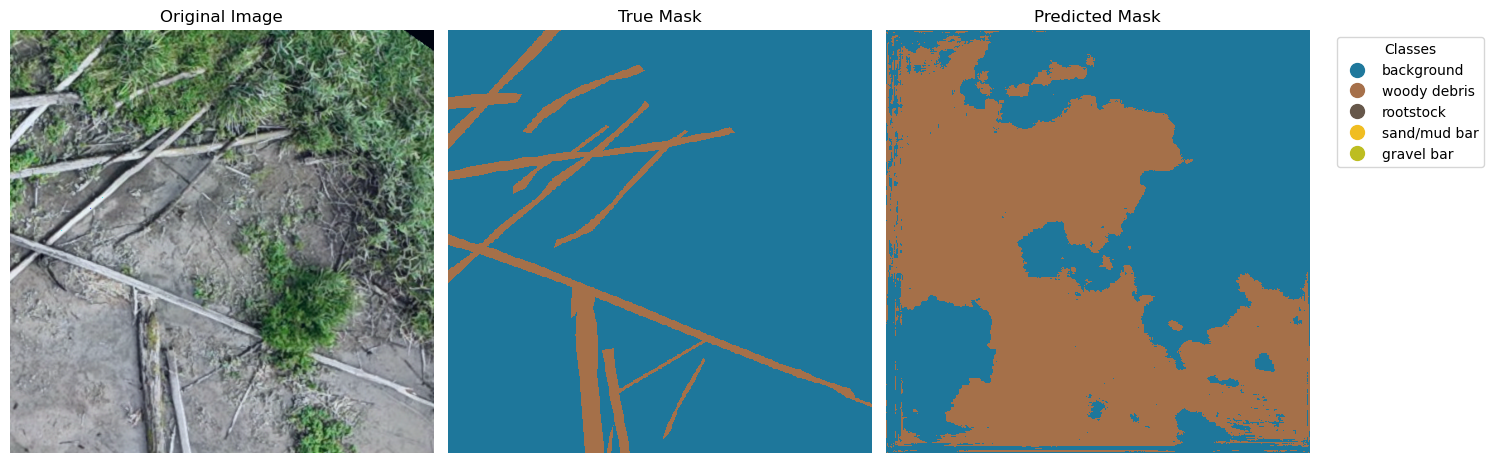

In [ ]:
##################### Choose single patch by section and id
SECTION = "A04" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 30 # -------------------->> ADJUSTABLE
#####################
# 1432

# Name of chosen patch
test_patch_name = f"{SECTION}_patch_{TEST_PATCH_ID}.npy"

visualization_utils.visualize_prediction(test_patch_name, test_loader, loaded_model, device, 
                                         reversed_codes, configs_sc.HYPERPARAMETERS["custom_colors"], show = True)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

def visualize_all_test_patches(test_loader, model, device, reversed_codes, custom_colors, output_pdf):
    """
    Iterates over all patches in the test DataLoader, calls the visualize_prediction function 
    for each patch, and saves each visualization as a separate page in a multi-page PDF.
    
    Args:
        test_loader (DataLoader): PyTorch DataLoader containing test images and masks.
        model (torch.nn.Module): Trained model for generating predictions.
        device (torch.device): Device to perform computations on.
        reversed_codes (list): List of class names corresponding to class indices.
        custom_colors (list): List of custom color definitions for each class.
        output_pdf (str): Filename for the output PDF.
    """
    # Create a PdfPages object to store multiple pages
    pdf = PdfPages(output_pdf)
    
    # Iterate over each batch in the test DataLoader
    for batch in test_loader:
        names, images, masks = batch
        # Send images and masks to the specified device
        images, masks = images.to(device), masks.to(device)
        # Iterate over each patch in the current batch
        for patch_name in names:
            # Call visualize_prediction function to generate the plot for this patch.
            # Note: The function searches for the patch in the test_loader based on patch_name.
            visualization_utils.visualize_prediction(patch_name, test_loader, model, device, 
                                                     reversed_codes, custom_colors, show = False)
            # Get the current figure
            fig = plt.gcf()
            # Save the current figure as a new page in the PDF
            pdf.savefig(fig)
            # Close the figure to free memory
            plt.close(fig)
    
    # Close the PDF file
    pdf.close()
    print(f"Saved all test predictions to {output_pdf}")

visualize_all_test_patches(test_loader, loaded_model, device, reversed_codes, 
                           configs_sc.HYPERPARAMETERS["custom_colors"], 
                           output_pdf = "/home/sc.uni-leipzig.de/rf37uqip/MoSE/saved_models/visual_2class_NOdataaug_30.pdf")


## Citing

In [ ]:
# @misc{Iakubovskii:2019,
#   Author = {Pavel Iakubovskii},
#   Title = {Segmentation Models Pytorch},
#   Year = {2019},
#   Publisher = {GitHub},
#   Journal = {GitHub repository},
#   Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
# }